# Stock Modeling Baseline with Renovation

In [ ]:
# Authors: gracecaj@stud.ntnu.no, sbaarak@stud.ntnu.no, & annakale@stud.ntnu.no
# Date: 20/02/2024

In [ ]:
    """_In this file we recreate our model in code and run the baseline 
    scenario TRENDS using it_
    """

### Import packages needed

In [42]:
#%%
#* Import the code needed
import os
from pathlib import Path
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from decimal import *
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import  norm, lognorm
from typing import List
import warnings

### Set directory path

In [43]:
#%%
#* Define paths
directory_path = Path('../../')

### Import datasets

In [44]:
# Import regression model data for population projections.
pop = pd.read_excel(
    directory_path / 'data' / 'regression_data' 
    / 'Population' / 'regression_Population.xlsx',
    index_col=0)

# Import regression model data for Persons per Dwelling (PpD).
PpD = pd.read_excel(
    directory_path / 'data' / 'regression_data' 
    / 'PpD' / 'regression_PpD.xlsx',
    index_col=0)

# Import regression model data for Useful Floor Area per Dwelling (UFApD).
UFApD = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 
    'UFApD' / 'UFApD_new.xlsx',
    index_col=0)

# Import a dataset showing the percentage of certain types of dwellings 
# at different age classes.
TS_cj = pd.read_excel(
    directory_path / 'data' / 'cleaned_and_combined_data' / 
    'Type_Split' / 'type_split_clean.xlsx',
    sheet_name='Sheet4', index_col=0)

# Import regression data for dwelling lifetime.
lifetime = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 
    'Dwelling_Lifetime' / 'lifetime_regression.xlsx',
    index_col=0)

# Import regression data for standard deviation of dwelling lifetime.
lifetime_standard_deviation = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 
    'Dwelling_Lifetime' / 'lifetime_regression.xlsx',
    index_col=0)

# Import Energy Demand for Single Family Homes (SFH) for different 
# levels of renovation for all years from 1600 to 2050.
EI_SFH = pd.read_excel(directory_path / 'data' / 
                       'regression_data' / 'Energy_Intensity' /
                       'Energy_and_Carbon_Intensity_Reformatted.xlsx',
    sheet_name='SFH_Energy_Demand', index_col=0)

# Import Energy Demand for Terraced Houses (TH) for different levels of 
# renovation for all years from 1600 to 2050.
EI_TH = pd.read_excel(directory_path / 'data' / 
                      'regression_data' / 'Energy_Intensity' / 
                      'Energy_and_Carbon_Intensity_Reformatted.xlsx',
    sheet_name='TH_Energy_Demand', index_col=0)

# Import Energy Demand for Apartment Blocks (AB) for different levels of 
# renovation for all years from 1600 to 2050.   
EI_AB = pd.read_excel(directory_path / 'data' / 
                      'regression_data' / 'Energy_Intensity' / 
                      'Energy_and_Carbon_Intensity_Reformatted.xlsx',
    sheet_name='AB_Energy_Demand', index_col=0)

# Import Carbon Intensity for Single Family Homes (SFH) for different levels 
# of renovation for all years from 1600 to 2050.   
CI_SFH = pd.read_excel(directory_path / 'data' / 'regression_data' /
                       'Energy_Intensity' / 
                       'Energy_and_Carbon_Intensity_Reformatted.xlsx',
    sheet_name='SFH_Carbon_new', index_col=0)

# Import Carbon Intensity for Terraced Houses (TH) for different levels 
# of renovation for all years from 1600 to 2050.     
CI_TH = pd.read_excel(directory_path / 'data' / 'regression_data' /
                      'Energy_Intensity' /
                      'Energy_and_Carbon_Intensity_Reformatted.xlsx',
    sheet_name='TH_Carbon_new', index_col=0)

# Import Carbon Intensity for Apartment Blocks (AB) for different levels 
# of renovation for all years from 1600 to 2050.      
CI_AB = pd.read_excel(directory_path / 'data' / 'regression_data' /
                      'Energy_Intensity' /
                      'Energy_and_Carbon_Intensity_Reformatted.xlsx',
    sheet_name='AB_Carbon_new', index_col=0)

### Seperate out the lifetime and standard deviation datasets

In [45]:
# Drop the 'Avg_lifetime' column from the lifetime_standard_deviation DataFrame.
lifetime_standard_deviation = lifetime_standard_deviation.drop(
    'Avg_lifetime', axis=1)

# Extract the 'Avg_lifetime' column from the lifetime DataFrame and convert it 
# to a NumPy array.
# This line focuses on isolating the average lifetime data and preparing it for 
# numerical operations that might be more efficiently handled with arrays.
lifetime = lifetime.loc[:, 'Avg_lifetime'].to_numpy()

# Extract the 'std_dev' column from the modified lifetime_standard_deviation 
# DataFrame and convert it to a NumPy array.
lifetime_standard_deviation = lifetime_standard_deviation.loc[
    :,
    'std_dev'
].to_numpy()

### Import DSM module

In [46]:
# Get the directory path of the current script.
current = os.path.dirname(os.path.realpath('this'))
 
# Get the parent directory of the current directory.
parent = os.path.dirname(current)

# Construct the path to a directory named 'modules' located in the parent 
# directory.
module_path = parent + '/modules'

# Add the constructed module path to the system path.
sys.path.append(module_path)

# Import the DynamicStockModel Python Package.
from dynamic_stock_model import DynamicStockModel

# Import the renovation_state_modeling module under the alias r_s_m.
import renovation_state_modeling as r_s_m
from importlib import reload

# Reload the renovation_state_modeling module.
reload(r_s_m)

# Import specific functions and scripts from the renovation_state_modeling module.
from renovation_state_modeling import get_renovation_cycles
from renovation_state_modeling import RenovationStock
from renovation_state_modeling import EnergyIntensity

### Calculate stock from pop/PpD

In [47]:
# Calculate the stock at time t by dividing the population by 
# the number of persons per dwelling.
stock_t = np.divide(pop.drop_duplicates(),PpD)

C:\Users\grace\AppData\Local\Temp\ipykernel_46336\4106792660.py:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  stock_t = np.divide(pop.drop_duplicates(),PpD)


### Define a function that does the stock driven modeling

In [48]:
# Define a function that does the stock driven modeling.
def calculate_inflow_by_type(inflow_t):
    SFH_inflow = pd.DataFrame()
    TH_inflow = pd.DataFrame()
    AB_inflow = pd.DataFrame()

    # Iterate over each column in the inflow DataFrame, where each column 
    # represents a year.
    for year in inflow_t.columns:

        # For years up to and including 1900, calculate inflows for each 
        # dwelling type based on their percentage share from a separate 
        # DataFrame (TS_cj).
        if int(year) <= 1900:

            # Multiply inflow data for the year by the percentage of SFH 
            # before 1900
            iteration_SFH = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['before 1900','% SFH']
                    )
                )
            
            # Merge the yearly data to the SFH DataFrame.
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            
            # Repeat the process for TH and AB.
            iteration_TH = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['before 1900','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['before 1900','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        
        # Each subsequent block handles different historical periods by updating 
        # the range of years and the corresponding percentage data.
        # Similar logic is applied for each time range, updating the percentage 
        # data from TS_cj according to the time period.
        if int(year) >= 1901 and int(year) <= 1955:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1901-1955','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1901-1955','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1901-1955','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 1956 and int(year) <= 1970:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['1956 - 1970','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['1956 - 1970','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1956 - 1970','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 1971 and int(year) <= 1980:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['1971 - 1980','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['1971 - 1980','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['1971 - 1980','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 1981 and int(year) <= 1990:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['1981 - 1990','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['1981 - 1990','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['1981 - 1990','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 1991 and int(year) <= 2000:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['1991 - 2000','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['1991 - 2000','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['1991 - 2000','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 2001 and int(year) <= 2010:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['2001 - 2010','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['2001 - 2010','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['2001 - 2010','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 2011:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['2011 and after','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['2011 and after','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                        inflow_t.loc[:,year],
                        TS_cj.loc['2011 and after','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
    
    # After processing all years, return the inflows for each dwelling type.
    return SFH_inflow, TH_inflow, AB_inflow

### Calculate inflow by type

In [49]:
# Define the function 'stock_driven_model' that calculates material inflow 
# into different types of dwellings based on the given stock data.
def stock_driven_model(stock):

    # The model uses a timeline from 1600 to 2050, the population data from 
    # the 'stock' DataFrame as the stock input, and assumes a normal 
    # distribution for the lifespan of these stocks with given mean and 
    # standard deviation.
    dwellings_stock_driven = DynamicStockModel(t=np.arange(1600, 2051),
                         s=stock['Pop'].to_numpy(),
                         lt={'Type': 'Normal', 
                             'Mean': lifetime,
                             'StdDev': lifetime_standard_deviation 
                             }
                        )
    
    # Calculate the stock dynamics, ensuring that any negative inflows 
    # (which are physically impossible) are corrected.
    dwellings_stock_driven.compute_stock_driven_model(
        NegativeInflowCorrect = True)
    
    # Convert the inflow data from the stock-driven model into a pandas 
    # DataFrame with years as indices.
    inflow_t = pd.DataFrame(dwellings_stock_driven.i,
                            index=np.arange(1600,2051))
    
    # Calculate the inflow by type of dwelling using the previously defined 
    # function and transpose the result for type-specific calculations.
    inflow_t_SFH, inflow_t_TH, inflow_t_AB = calculate_inflow_by_type(
        inflow_t.T)
    
    # Transpose the resulting DataFrames back to original orientation 
    # with years as columns to match the expected output format.
    inflow_t_SFH = inflow_t_SFH.T
    inflow_t_TH = inflow_t_TH.T
    inflow_t_AB = inflow_t_AB.T
    
    # Return the three DataFrames containing the inflow for SFH, TH, and AB.
    return inflow_t_SFH, inflow_t_TH, inflow_t_AB

### Run the stock driven model

In [50]:
# Run the stock-driven model using the provided stock data 'stock_t'.
i_SFH, i_TH, i_AB = stock_driven_model(stock_t)

### Define a function that does the inflow driven modeling

In [51]:
# Define the function 'inflow_driven_model' to calculate stock dynamics 
# based on the specified inflow.
def inflow_driven_model(inflow):
    
    # The model uses a timeline from 1600 to 2050, takes the first element 
    # of the 'inflow' array for inflow data, and assumes a normal distribution 
    # for the lifespan of these inflows with given mean and standard deviation.
    dwellings_inflow_driven = DynamicStockModel(t=np.arange(1600, 2051),
                    i=inflow[0],
                    lt={'Type': 'Normal', 
                        'Mean': lifetime,
                        'StdDev': lifetime_standard_deviation 
                        }
                    )
    
    # Calculate the stock dynamics as a function of inflow. This function 
    # calculates the changes in stock count based on the provided inflow data.
    dwellings_inflow_driven.compute_s_c_inflow_driven()

    # Calculate the total stock after accounting for inflow. 
    # This method aggregates all the individual stock changes over time 
    # to provide a cumulative view.
    dwellings_inflow_driven.compute_stock_total()

    # Calculate the outflow from the stock and stock change.
    dwellings_inflow_driven.compute_o_c_from_s_c()

    # Return the stock by cohorts (s_c), the stock (s), and the 
    # outflow by cohorts (o_c) as results of the model.
    return dwellings_inflow_driven.s_c, dwellings_inflow_driven.s, \
        dwellings_inflow_driven.o_c

### Run the inflow driven model

In [52]:
# Run the inflow-driven model for different dwelling types.
s_c_SFH, s_SFH, o_SFH = inflow_driven_model(i_SFH)
s_c_TH, s_TH, o_TH = inflow_driven_model(i_TH)
s_c_AB, s_AB, o_AB = inflow_driven_model(i_AB)

In [53]:
# Rename a '0' column in the DataFrame `i_SFH`, `i_TH`, and `i_AB`.
i_SFH.rename(columns={0:'SFH'}, inplace=True)
i_TH.rename(columns={0:'TH'}, inplace=True)
i_AB.rename(columns={0:'AB'}, inplace=True)

### Make s_c arrays into dataframes for easier use

In [54]:
# Convert the array 's_SFH' into a DataFrame for ease of manipulation and 
# set its index using the index from another DataFrame 'UFApD'.
s_SFH_df = pd.DataFrame(s_SFH)
s_SFH_df = s_SFH_df.set_index(UFApD.index)
s_SFH_df.columns = ['SFH']

# Convert the array 's_TH' into a DataFrame, set the same index for 
# consistent comparison.
s_TH_df = pd.DataFrame(s_TH)
s_TH_df = s_TH_df.set_index(UFApD.index)
s_TH_df.columns = ['TH']

# Convert the array 's_AB' into a DataFrame, set the same index.
s_AB_df = pd.DataFrame(s_AB)
s_AB_df = s_AB_df.set_index(UFApD.index)
s_AB_df.columns = ['AB']

# Convert the 's_c_SFH' array into a DataFrame, set the same index.
s_c_SFH_df = pd.DataFrame(s_c_SFH)
s_c_SFH_df = s_c_SFH_df.set_index(UFApD.index)
s_c_SFH_df.columns = np.arange(1600, 2051)

# Convert the 's_c_TH' array into a DataFrame, set the same index.
s_c_TH_df = pd.DataFrame(s_c_TH)
s_c_TH_df = s_c_TH_df.set_index(UFApD.index)
s_c_TH_df.columns = np.arange(1600, 2051)

# Convert the 's_c_AB' array into a DataFrame, set the same index.
s_c_AB_df = pd.DataFrame(s_c_AB)
s_c_AB_df = s_c_AB_df.set_index(UFApD.index)
s_c_AB_df.columns = np.arange(1600, 2051)

# Convert 'i_SFH' inflow data into a DataFrame and set the index.
i_SFH_df = pd.DataFrame(i_SFH)
i_SFH_df = i_SFH_df.set_index(UFApD.index)

# Convert outflow data 'o_SFH' into a DataFrame and set the index.
o_SFH_df = pd.DataFrame(o_SFH)
o_SFH_df = o_SFH_df.set_index(UFApD.index)
o_SFH_df.columns = np.arange(1600, 2051)

# Convert inflow data 'i_TH' into a DataFrame and set the index.
i_TH_df = pd.DataFrame(i_TH)
i_TH_df = i_TH_df.set_index(UFApD.index)

# Convert outflow data 'o_TH' into a DataFrame and set the index.
o_TH_df = pd.DataFrame(o_TH)
o_TH_df = o_TH_df.set_index(UFApD.index)
o_TH_df.columns = np.arange(1600, 2051)

# Convert inflow data 'i_AB' into a DataFrame and set the index.
i_AB_df = pd.DataFrame(i_AB)
i_AB_df = i_AB_df.set_index(UFApD.index)

# Convert outflow data 'o_AB' into a DataFrame and set the index.
o_AB_df = pd.DataFrame(o_AB)
o_AB_df = o_AB_df.set_index(UFApD.index)
o_AB_df.columns = np.arange(1600, 2051)

### Aggregate s_c dataframes into the cohorts from tabula for each type for plotting

In [55]:
# Aggregate the Single Family Homes (SFH) stock data into specific historical 
# cohorts for easier analysis and visualization.
# The data from 's_c_SFH_df' is summed across specified year ranges to create 
# aggregated cohorts.
SFH_stock_by_tabula_cohort = pd.DataFrame(
    data={
        'pre-1955':
            pd.DataFrame(s_c_SFH_df).loc[:,'1600':'1955'].sum(axis=1),
        '1956-1970':
            pd.DataFrame(s_c_SFH_df).loc[:,'1956':'1970'].sum(axis=1),
        '1971-1980':
            pd.DataFrame(s_c_SFH_df).loc[:,'1971':'1980'].sum(axis=1),
        '1981-1990':
            pd.DataFrame(s_c_SFH_df).loc[:,'1981':'1990'].sum(axis=1),
        '1991-2000':
            pd.DataFrame(s_c_SFH_df).loc[:,'1991':'2000'].sum(axis=1),
        '2001-2010':
            pd.DataFrame(s_c_SFH_df).loc[:,'2001':'2010'].sum(axis=1),
        'post-2010':
            pd.DataFrame(s_c_SFH_df).loc[:,'2011':'2050'].sum(axis=1)
        }
        )

# Repeat the aggregation process for Terraced Houses (TH) using the same 
# cohort breakdowns.
TH_stock_by_tabula_cohort = pd.DataFrame(
    data={
        'pre-1955':
            pd.DataFrame(s_c_TH_df).loc[:,'1600':'1955'].sum(axis=1),
        '1956-1970':
            pd.DataFrame(s_c_TH_df).loc[:,'1956':'1970'].sum(axis=1),
        '1971-1980':
            pd.DataFrame(s_c_TH_df).loc[:,'1971':'1980'].sum(axis=1),
        '1981-1990':
            pd.DataFrame(s_c_TH_df).loc[:,'1981':'1990'].sum(axis=1),
        '1991-2000':
            pd.DataFrame(s_c_TH_df).loc[:,'1991':'2000'].sum(axis=1),
        '2001-2010':
            pd.DataFrame(s_c_TH_df).loc[:,'2001':'2010'].sum(axis=1),
        'post-2010':
            pd.DataFrame(s_c_TH_df).loc[:,'2011':'2050'].sum(axis=1)
        }
    )

# Similarly, aggregate the Apartment Blocks (AB) stock data by the same 
# cohorts for consistency and comparison.
AB_stock_by_tabula_cohort = pd.DataFrame(
    data={
        'pre-1955':
            pd.DataFrame(s_c_AB_df).loc[:,'1600':'1955'].sum(axis=1),
        '1956-1970':
            pd.DataFrame(s_c_AB_df).loc[:,'1956':'1970'].sum(axis=1),
        '1971-1980':
            pd.DataFrame(s_c_AB_df).loc[:,'1971':'1980'].sum(axis=1),
        '1981-1990':
            pd.DataFrame(s_c_AB_df).loc[:,'1981':'1990'].sum(axis=1),
        '1991-2000':
            pd.DataFrame(s_c_AB_df).loc[:,'1991':'2000'].sum(axis=1),
        '2001-2010':
            pd.DataFrame(s_c_AB_df).loc[:,'2001':'2010'].sum(axis=1),
        'post-2010':
            pd.DataFrame(s_c_AB_df).loc[:,'2011':'2050'].sum(axis=1)
        }
    )

### Calculate total stock (s_total), total stock by cohort (s_c_total)

### Calculate stock_changes by inflow - outflow for each type and aggregated

### Calculate total inflows and outflows

In [56]:
# Calculate the total stock by summing up the stocks of SFH, TH, AB.
s_total = s_SFH_df + s_TH_df + s_AB_df

# Calculate total stock aggregated by tabula cohort by summing up the 
# corresponding cohorts for SFH, TH, and AB.
total_stock_by_tabula_cohort = (SFH_stock_by_tabula_cohort
    + TH_stock_by_tabula_cohort + AB_stock_by_tabula_cohort)

# Calculate the stock change for SFH by subtracting the sum of outflows 
# from the inflows.
stock_change_SFH = i_SFH_df.values - pd.DataFrame(o_SFH_df.sum(axis=1))
stock_change_SFH = pd.DataFrame(
    stock_change_SFH, index=np.arange(1600,2051))

# Repeat the calculation of stock change for TH.
stock_change_TH = i_TH_df.values - pd.DataFrame(o_TH_df.sum(axis=1))
stock_change_TH = pd.DataFrame(
    stock_change_TH, index=np.arange(1600,2051))

# Repeat the calculation of stock change for AB.
stock_change_AB = i_AB_df.values - pd.DataFrame(o_AB_df.sum(axis=1))
stock_change_AB = pd.DataFrame(
    stock_change_AB, index=np.arange(1600,2051))

# Calculate the total stock change by summing the stock changes of SFH, 
# TH, and AB.
stock_change_total = (stock_change_SFH + stock_change_TH
                      + stock_change_AB)

# Sum the inflows from all dwelling types to get the total inflows.
i_total = i_SFH_df.values + i_TH_df.values + i_AB_df.values
i_total = pd.DataFrame(i_total, index=np.arange(1600,2051))

# Sum the outflows from all dwelling types to compute the total outflows.
o_total = o_SFH_df + o_TH_df + o_AB_df

### Convert number of dwellings into floor area by DSM cohort

In [57]:
# Convert the stock by cohorts for SFH, TH, AB into useful floor area 
# by multiplying the stock by cohorts splitted by dwelling type with the 
# respective Useful Floor Area per Dwelling (UFApD).
s_UFA_c_SFH = s_c_SFH_df @ np.diag(UFApD['UFApD SFH'])
s_UFA_c_SFH = pd.DataFrame(s_UFA_c_SFH)
s_UFA_c_SFH.columns = np.arange(1600, 2051)

s_UFA_c_TH = s_c_TH_df @ np.diag(UFApD['UFApD TH'])
s_UFA_c_TH = pd.DataFrame(s_UFA_c_TH)
s_UFA_c_TH.columns = np.arange(1600, 2051)

s_UFA_c_AB = s_c_AB_df @ np.diag(UFApD['UFApD AB'])
s_UFA_c_AB = pd.DataFrame(s_UFA_c_AB)
s_UFA_c_AB.columns = np.arange(1600, 2051)

# Multiply inflow data for SFH by the Useful Floor Area per Dwelling (UFApD) 
# to convert dwellings inflows into floor area.
i_SFH_UFA = i_SFH_df.mul(UFApD['UFApD SFH'].values, axis=0)
i_SFH_UFA = pd.DataFrame(i_SFH_UFA)

# Convert outflow data for SFH into floor area by using matrix multiplication 
# with the diagonal matrix of UFApD.
o_SFH_UFA = o_SFH_df @ np.diag(UFApD['UFApD SFH'])
o_SFH_UFA = pd.DataFrame(o_SFH_UFA)
o_SFH_UFA.columns = np.arange(1600, 2051)

# Multiply inflow data for TH by the Useful Floor Area per Dwelling (UFApD) 
# to convert dwellings inflows into floor area.
i_TH_UFA = i_TH_df.mul(UFApD['UFApD TH'].values, axis=0)
i_TH_UFA = pd.DataFrame(i_TH_UFA)

# Convert outflow data for TH into floor area by using matrix multiplication 
# with the diagonal matrix of UFApD.
o_TH_UFA = o_TH_df @ np.diag(UFApD['UFApD TH'])
o_TH_UFA = pd.DataFrame(o_TH_UFA)
o_TH_UFA.columns = np.arange(1600, 2051)

# Multiply inflow data for AB by the Useful Floor Area per Dwelling (UFApD) 
# to convert dwellings inflows into floor area.
i_AB_UFA = i_AB_df.mul(UFApD['UFApD AB'].values, axis=0)
i_AB_UFA = pd.DataFrame(i_AB_UFA)

# Convert outflow data for AB into floor area by using matrix multiplication 
# with the diagonal matrix of UFApD.
o_AB_UFA = o_AB_df @ np.diag(UFApD['UFApD AB'])
o_AB_UFA = pd.DataFrame(o_AB_UFA)
o_AB_UFA.columns = np.arange(1600, 2051)

### Make s_c_UFA arrays into dataframes for easier use

In [58]:
# Make s_c_UFA arrays into dataframes for easier use for all dwelling types.
s_UFA_c_SFH_df = pd.DataFrame(s_UFA_c_SFH)
s_UFA_c_SFH_df = s_UFA_c_SFH_df.set_index(UFApD.index)
s_UFA_c_SFH_df.columns = np.arange(1600, 2051)
s_UFA_c_SFH_df

s_UFA_c_TH_df = pd.DataFrame(s_UFA_c_TH)
s_UFA_c_TH_df = s_UFA_c_TH_df.set_index(UFApD.index)
s_UFA_c_TH_df.columns = np.arange(1600, 2051)
s_UFA_c_TH_df

s_UFA_c_AB_df = pd.DataFrame(s_UFA_c_AB)
s_UFA_c_AB_df = s_UFA_c_AB_df.set_index(UFApD.index)
s_UFA_c_AB_df.columns = np.arange(1600, 2051)
s_UFA_c_AB_df

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.270719e+06,1.277599e+06,1.284684e+06,1.291977e+06,1.299486e+06,1.307213e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.270718e+06,1.277599e+06,1.284683e+06,1.291977e+06,1.299486e+06,1.307213e+06,1.315163e+06,0.000000e+00,0.000000e+00,0.000000e+00
2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.270718e+06,1.277598e+06,1.284683e+06,1.291977e+06,1.299486e+06,1.307213e+06,1.315163e+06,1.323338e+06,0.000000e+00,0.000000e+00


### Aggregate s_c dataframes into the cohorts from tabula for each type for plotting

In [59]:
# Provide the cohort aggregation for SFH, TH, AB to analyze different 
# dwelling types in similar historical cohorts.
SFH_UFA_stock_by_tabula_cohort = pd.DataFrame(
    data={
        'pre-1955': (pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1600':'1955']
                        .sum(axis=1)),
        '1956-1970': (pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1956':'1970']
                        .sum(axis=1)),
        '1971-1980': (pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1971':'1980']
                        .sum(axis=1)),
        '1981-1990': (pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1981':'1990']
                        .sum(axis=1)),
        '1991-2000': (pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1991':'2000']
                        .sum(axis=1)),
        '2001-2010': (pd.DataFrame(s_UFA_c_SFH_df).loc[:,'2001':'2010']
                        .sum(axis=1)),
        'post-2010': (pd.DataFrame(s_UFA_c_SFH_df).loc[:,'2011':'2050']
                        .sum(axis=1))
    }
)

TH_UFA_stock_by_tabula_cohort = pd.DataFrame(
    data={
        'pre-1955': (pd.DataFrame(s_UFA_c_TH_df).loc[:,'1600':'1955']
                        .sum(axis=1)),
        '1956-1970': (pd.DataFrame(s_UFA_c_TH_df).loc[:,'1956':'1970']
                        .sum(axis=1)),
        '1971-1980': (pd.DataFrame(s_UFA_c_TH_df).loc[:,'1971':'1980']
                        .sum(axis=1)),
        '1981-1990': (pd.DataFrame(s_UFA_c_TH_df).loc[:,'1981':'1990']
                        .sum(axis=1)),
        '1991-2000': (pd.DataFrame(s_UFA_c_TH_df).loc[:,'1991':'2000']
                        .sum(axis=1)),
        '2001-2010': (pd.DataFrame(s_UFA_c_TH_df).loc[:,'2001':'2010']
                        .sum(axis=1)),
        'post-2010': (pd.DataFrame(s_UFA_c_TH_df).loc[:,'2011':'2050']
                        .sum(axis=1))
    }
)

AB_UFA_stock_by_tabula_cohort = pd.DataFrame(
    data={
        'pre-1955':  (pd.DataFrame(s_UFA_c_AB_df).loc[:,'1600':'1955']
                        .sum(axis=1)),
        '1956-1970': (pd.DataFrame(s_UFA_c_AB_df).loc[:,'1956':'1970']
                        .sum(axis=1)),
        '1971-1980': (pd.DataFrame(s_UFA_c_AB_df).loc[:,'1971':'1980']
                        .sum(axis=1)),
        '1981-1990': (pd.DataFrame(s_UFA_c_AB_df).loc[:,'1981':'1990']
                        .sum(axis=1)),
        '1991-2000': (pd.DataFrame(s_UFA_c_AB_df).loc[:,'1991':'2000']
                        .sum(axis=1)),
        '2001-2010': (pd.DataFrame(s_UFA_c_AB_df).loc[:,'2001':'2010']
                        .sum(axis=1)),
        'post-2010': (pd.DataFrame(s_UFA_c_AB_df).loc[:,'2011':'2050']
                        .sum(axis=1))
   }
)

### Calculate total stock (s_total), total stock by cohort (s_c_total)

### Calculate stock_changes by inflow - outflow for each type and aggregated

### Calculate total inflows and outflows

In [60]:
# Provide a comprehensive view of the total floor area managed across 
# all types of dwellings.
s_UFA_total = (s_UFA_c_SFH.sum(axis=1) + s_UFA_c_TH.sum(axis=1)
               + s_UFA_c_AB.sum(axis=1))

# Aggregate the total stock by tabula cohort across all dwelling types 
# for easier analysis and visualization.
total_stock_UFA_by_tabula_cohort = (SFH_UFA_stock_by_tabula_cohort
                                    + TH_UFA_stock_by_tabula_cohort
                                    + AB_UFA_stock_by_tabula_cohort)

# Calculate the stock change for SFH, TH, AB by subtracting outflows from 
# inflows, measured in floor area.
stock_change_SFH_UFA = (i_SFH_UFA.values
                        - pd.DataFrame(o_SFH_UFA.sum(axis=1)))
stock_change_SFH_UFA = pd.DataFrame(stock_change_SFH_UFA,
                                    index=np.arange(1600,2051))

stock_change_TH_UFA = (i_TH_UFA.values
                       - pd.DataFrame(o_TH_UFA.sum(axis=1)))
stock_change_TH_UFA = pd.DataFrame(stock_change_TH_UFA,
                                   index=np.arange(1600,2051))

stock_change_AB_UFA = (i_AB_UFA.values
                       - pd.DataFrame(o_AB_UFA.sum(axis=1)))
stock_change_AB_UFA = pd.DataFrame(stock_change_AB_UFA,
                                   index=np.arange(1600,2051))

# Combine the stock changes from all dwelling types to get a total perspective.
stock_change_total_UFA = (stock_change_SFH_UFA
                          + stock_change_TH_UFA
                          + stock_change_AB_UFA)

# Sum the inflows in floor area for all dwelling types to get a total inflow.
i_total_UFA = i_SFH_UFA.values + i_TH_UFA.values + i_AB_UFA.values
i_total_UFA = pd.DataFrame(i_total_UFA, index=np.arange(1600,2051))

# Sum the outflows in floor area for all dwelling types to calculate 
# a total outflow.
o_total_UFA = o_SFH_UFA + o_TH_UFA + o_AB_UFA

### Do renovation modeling AFTER conversion to UFA

Start with setting up renovation cycle

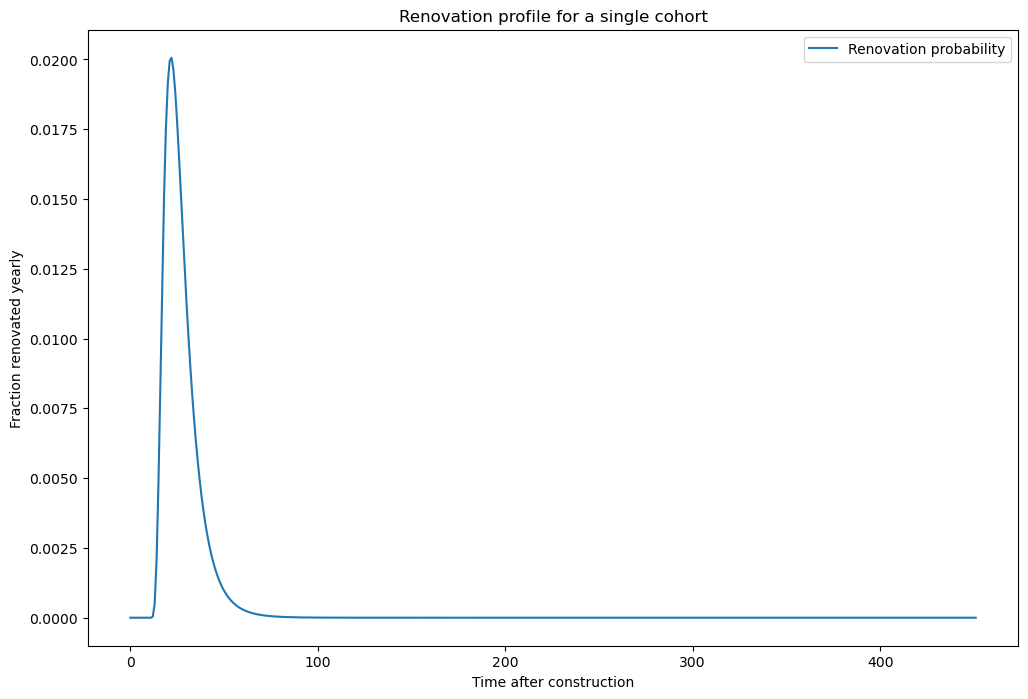

the actual mean of the outflow time in the first renovation cycles is at 9.0 years.


In [61]:
# Initialize the time interval for renovation modeling. 
time_interval = [
    0,
    s_UFA_c_SFH_df.index[-1] - s_UFA_c_SFH_df.index[0]+1
]
#time_interval = [1600, 2050]
#[1980, 2050] # for age of the cohorts

# Set the number of renovation cycles to 1, indicating that each cohort goes 
# through one major renovation cycle during the specified time interval.
no_cycles = 1

# Define the average duration between renovations. Here, 'ren_mean_avg' is set 
# to 20 years, meaning on average, a renovation occurs every 20 years for 
# each dwelling.
ren_mean_avg = 20

# Set the relative standard deviation of the renovation cycle duration 
# to 25% ('0.25').
ren_rel_std = 0.25

# Compute the renovation cycles using the specified parameters. This function 
# 'get_renovation_cycles' returns the distribution of renovation events over 
# the specified time interval, following a log-normal distribution.
renovation_cycle_avg = get_renovation_cycles(
    time_interval,
    no_cycles,
    ren_mean_cycle=ren_mean_avg,
    ren_rel_deviation=ren_rel_std,
    distribution='lognorm',
    show=True)

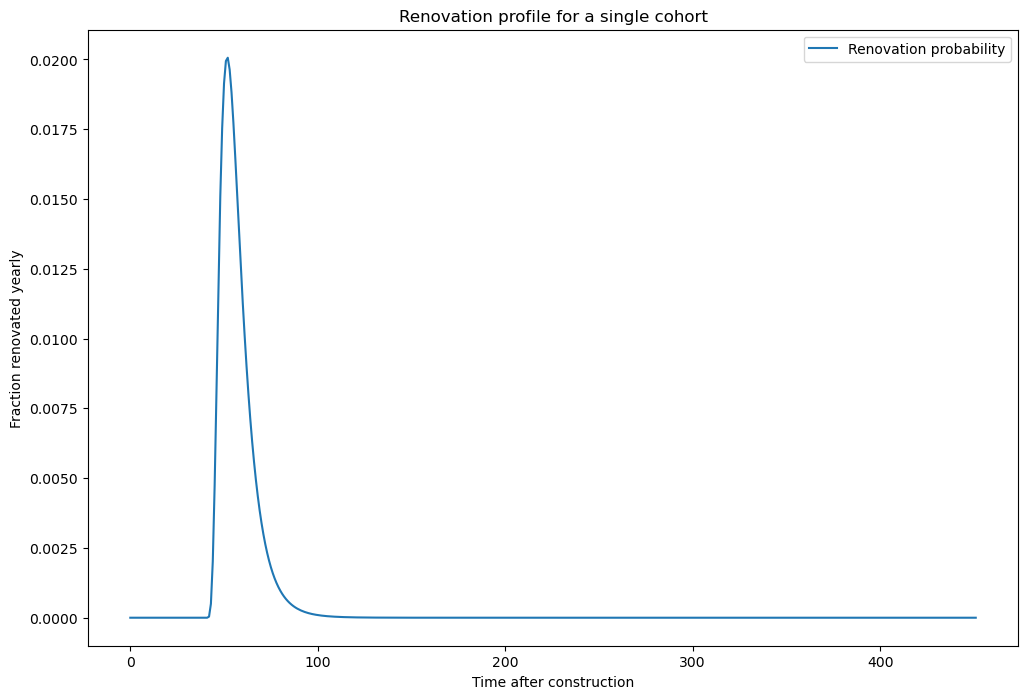

the actual mean of the outflow time in the first renovation cycles is at 19.0 years.


In [62]:
# This script initializes the same time interval for renovation modeling 
# as the previous script, ensuring coverage of the entire dataset.
time_interval = [
    0,
    int(s_UFA_c_SFH_df.index[-1]) - int(s_UFA_c_SFH_df.index[0])+1
]
#time_interval = [1600, 2050]
#[1980, 2050] # for age of the cohorts

# Maintains the same configuration with one major renovation cycle over 
# the specified time interval.
no_cycles = 1

# Sets the mean duration between renovations to 20 years, consistent with 
# the first model block.
ren_mean_adv = 20

# The relative standard deviation remains at 25%.
ren_rel_std = .25

# The significant change here is the addition of a 'loc' parameter set to 30 
# in the renovation cycle computation.
# This adjustment shifts the log-normal distribution used in the model, 
# delaying the start of renovation cycles.
renovation_cycle_adv = get_renovation_cycles(
    time_interval,
    no_cycles,
    ren_mean_cycle=ren_mean_adv,
    ren_rel_deviation=ren_rel_std,
    loc=30,
    distribution='lognorm',
    show=True)

Renovation stock model for Single Family Homes (SFH)

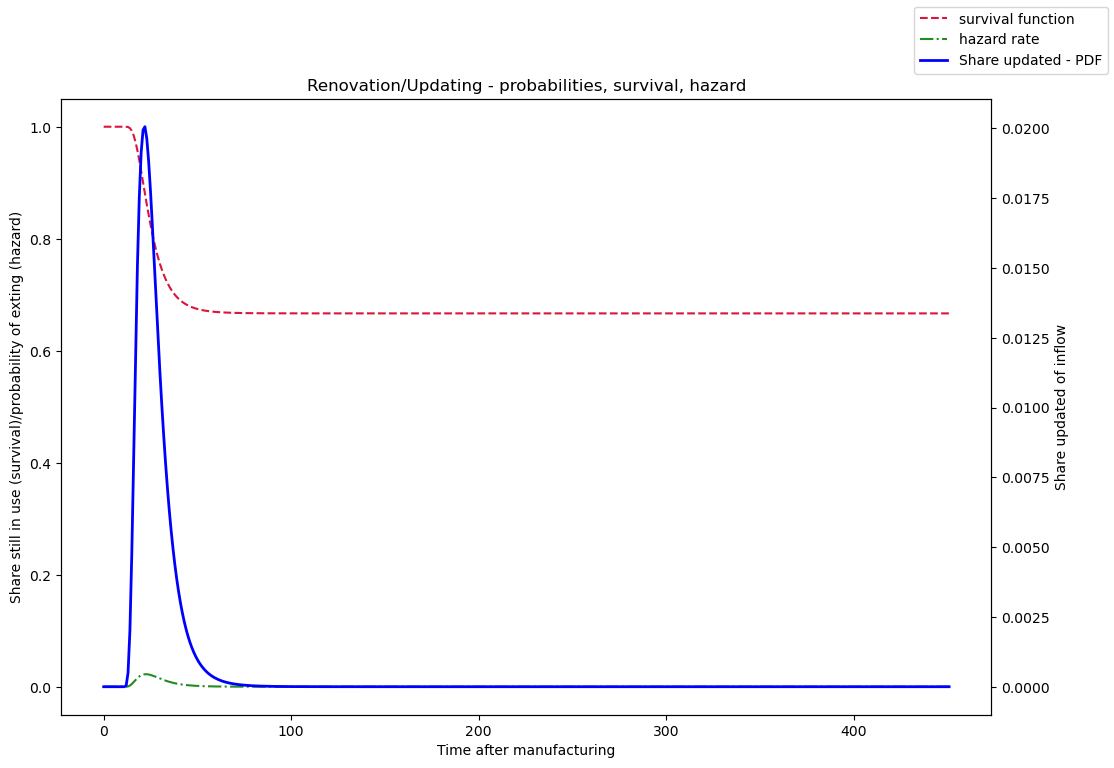

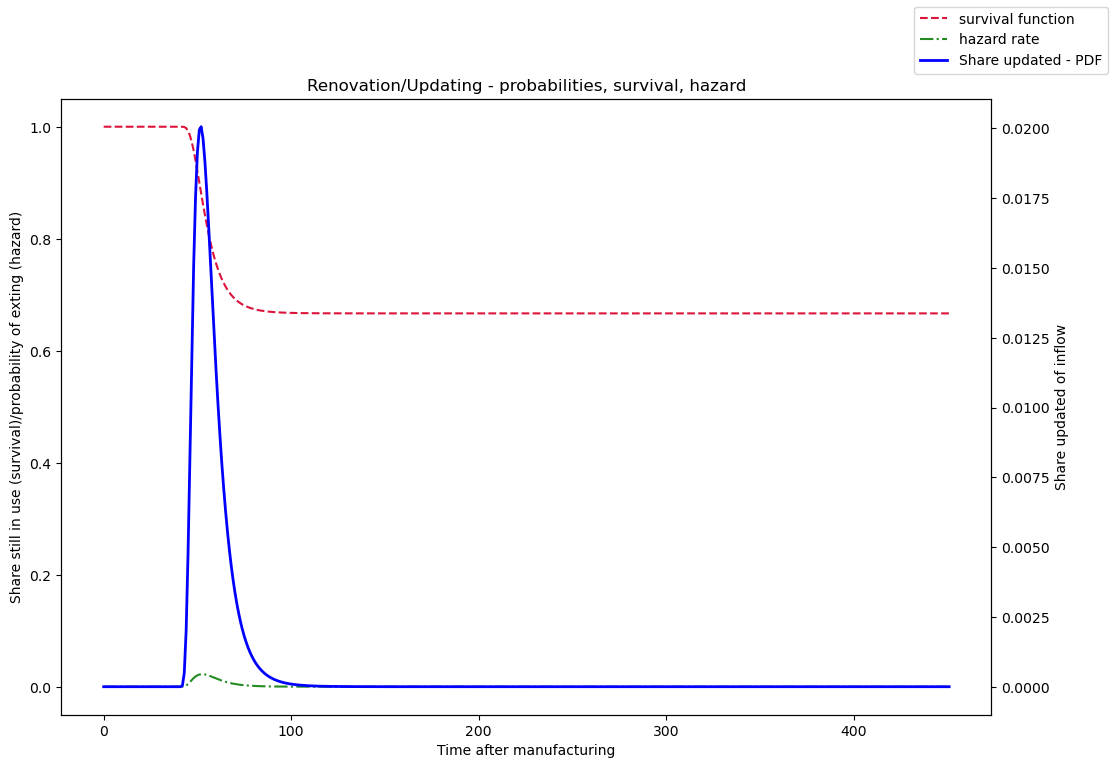

C:\Users\grace\OneDrive\Documents\Python\TEP4290_project\src/modules\renovation_state_modeling.py:382: UserWarning: Seems like your input stock contains non integers
  warnings.warn('Seems like your input stock contains non integers')


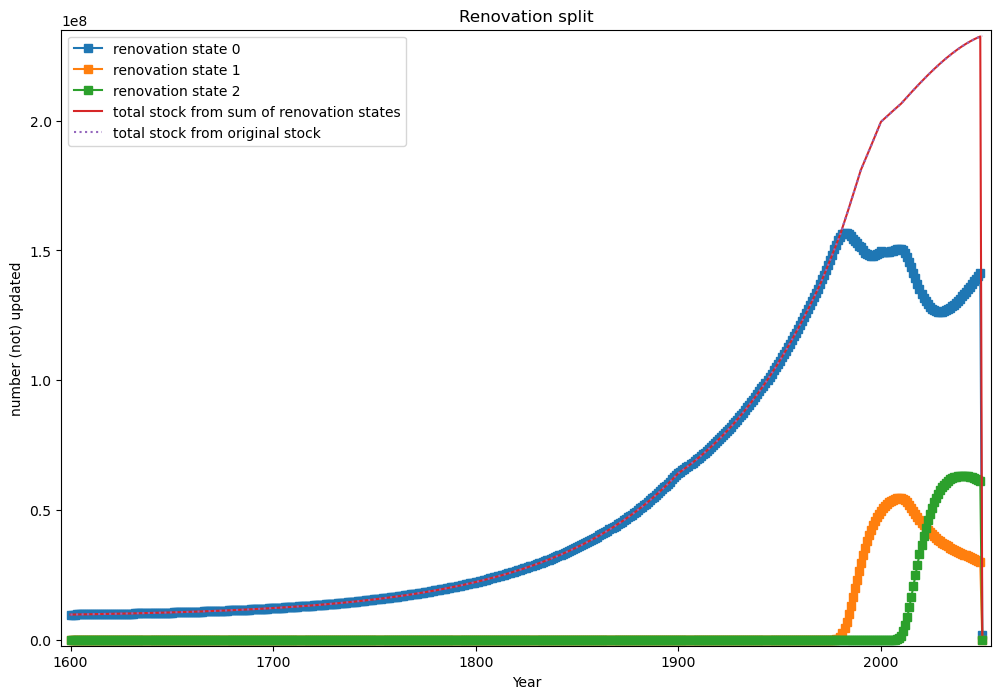

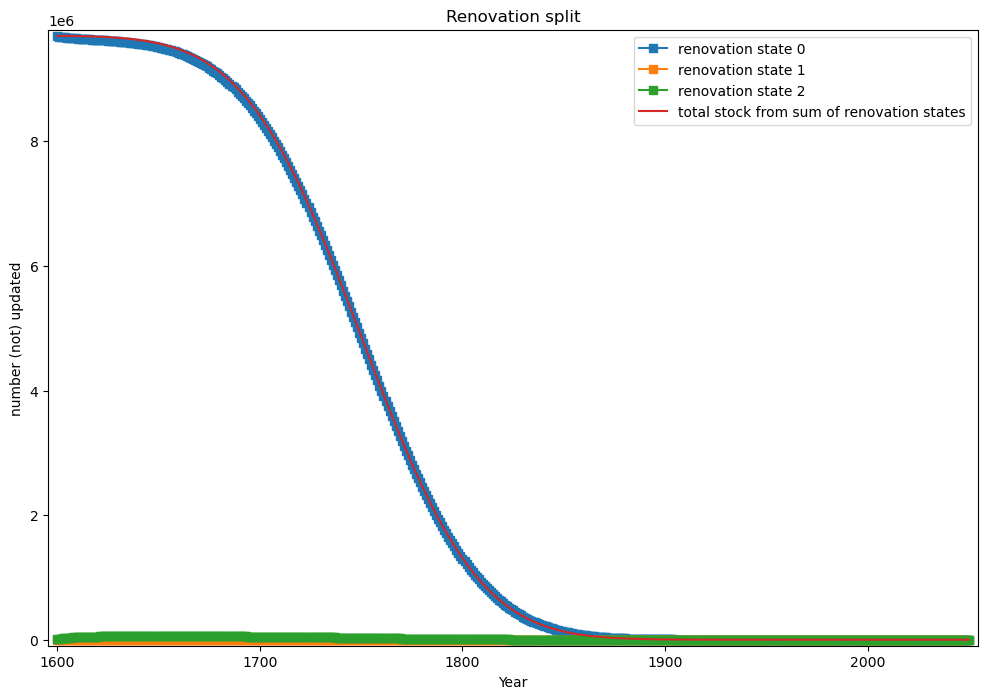

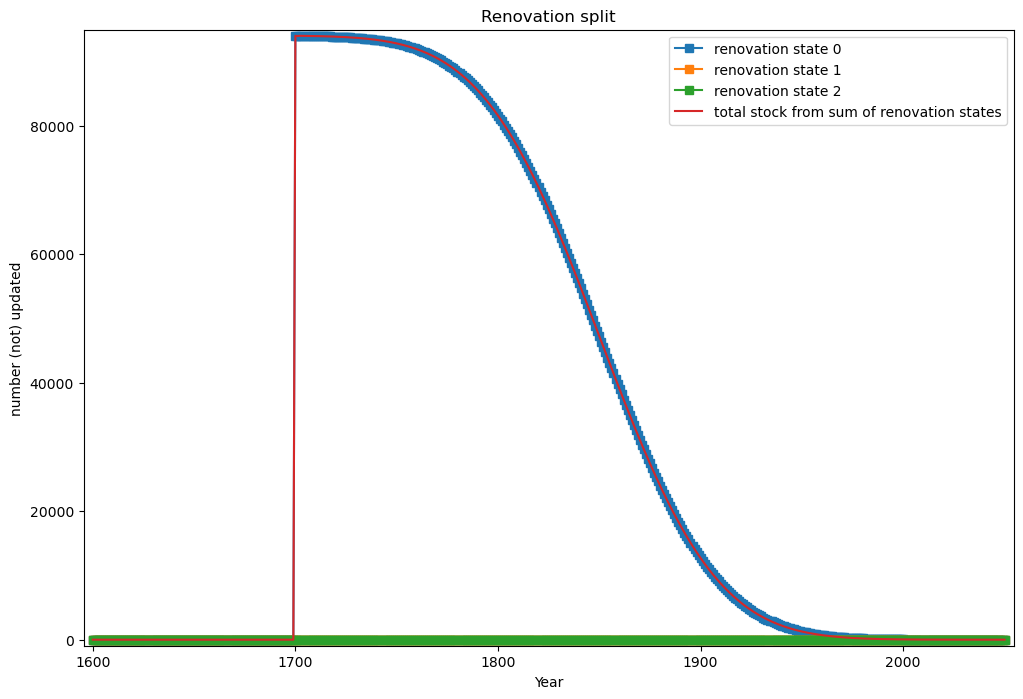

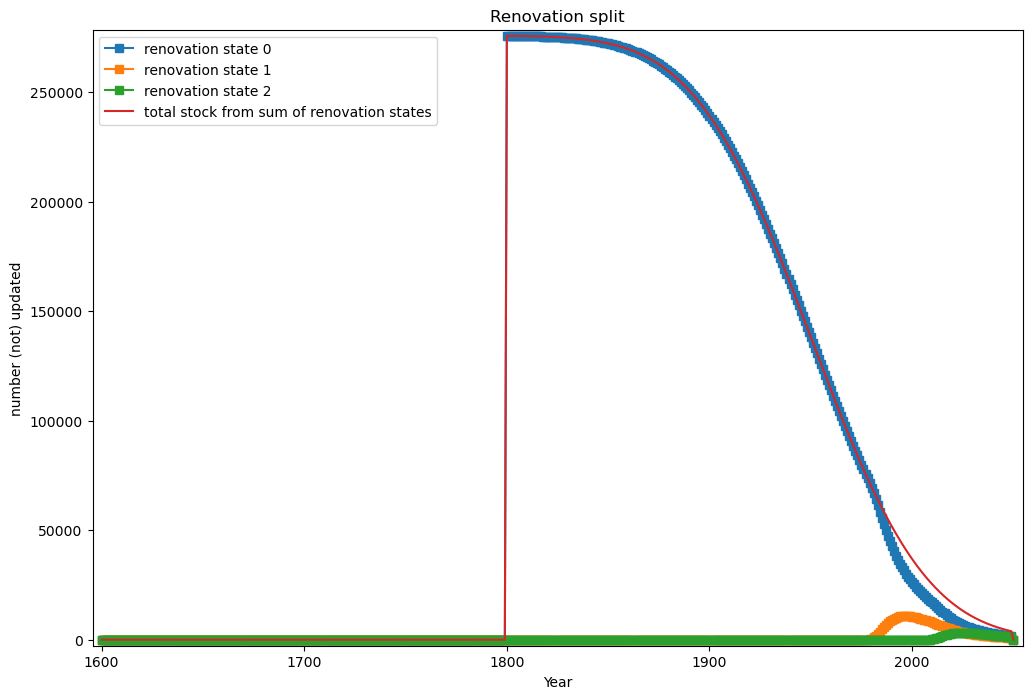

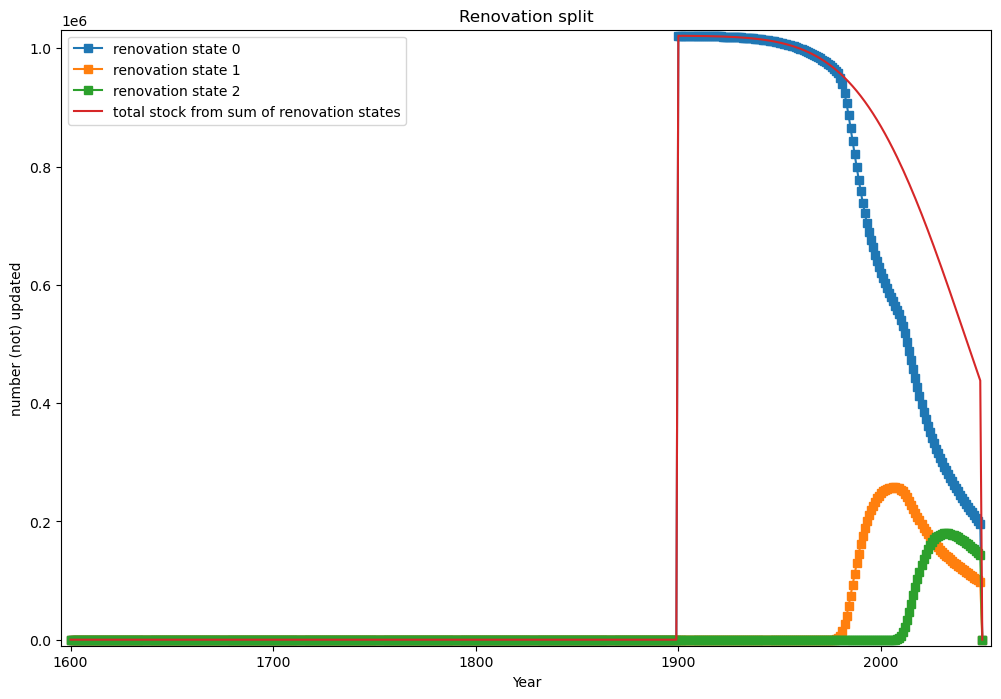

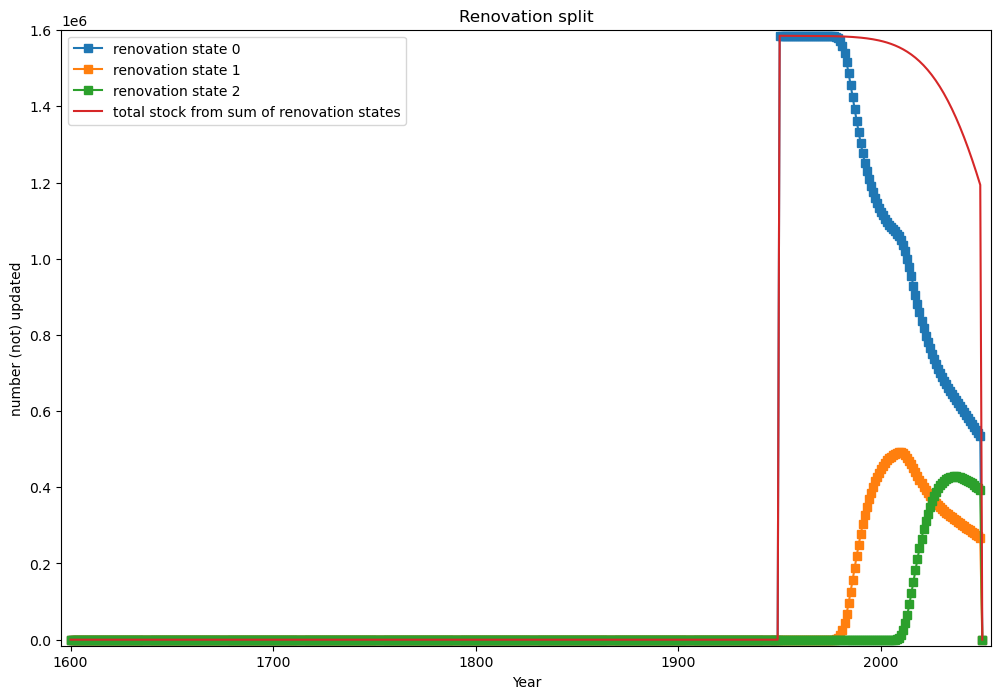

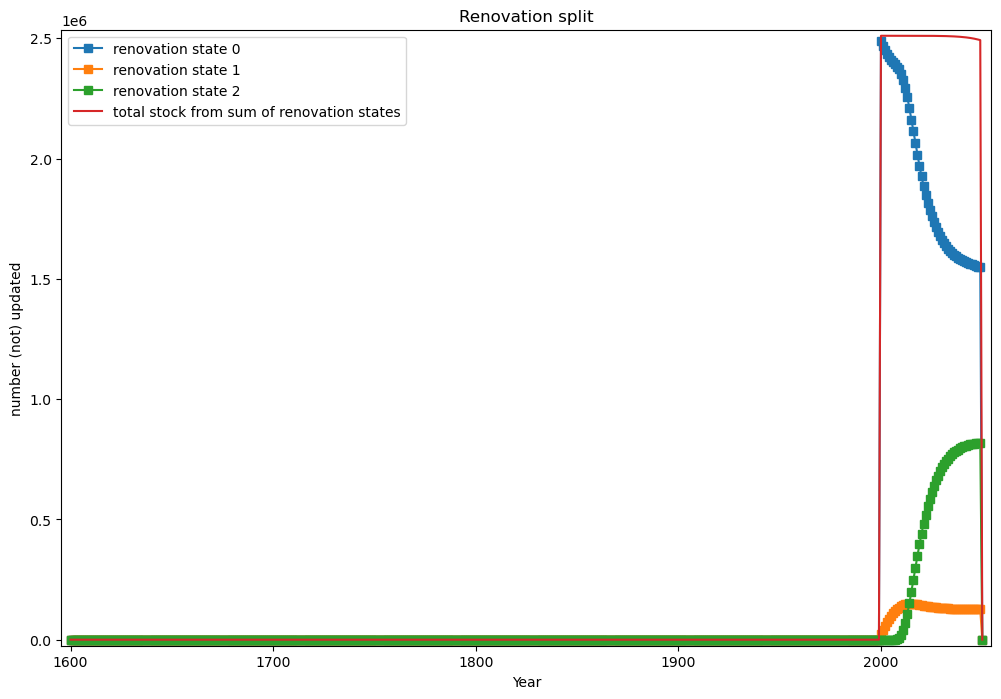

In [63]:
# Initialize the RenovationStock model for SFH.
ren_stock_model_SFH = RenovationStock(
    np.array(s_UFA_c_SFH), np.array(o_SFH_UFA), 
    [renovation_cycle_avg, renovation_cycle_adv], 
    np.array(s_UFA_c_SFH_df.index))

# Execute the renovation process within the model.
ren_stock_model_SFH.renovate()

# Plot the total stock after renovations for SFH.
ren_stock_model_SFH.plot_renovation_total_stock()

# Plot the state of renovation cohorts at specific time steps.
ren_stock_model_SFH.plot_renovation_states_cohort(
    [0,100,200,300,350,400])

# Extract the detailed stock data resolved by time and cohort after the 
# renovation processes.
stock_tcr_SFH = ren_stock_model_SFH.s_tc_p_r

Renovation stock model for Terraced Houses (TH)

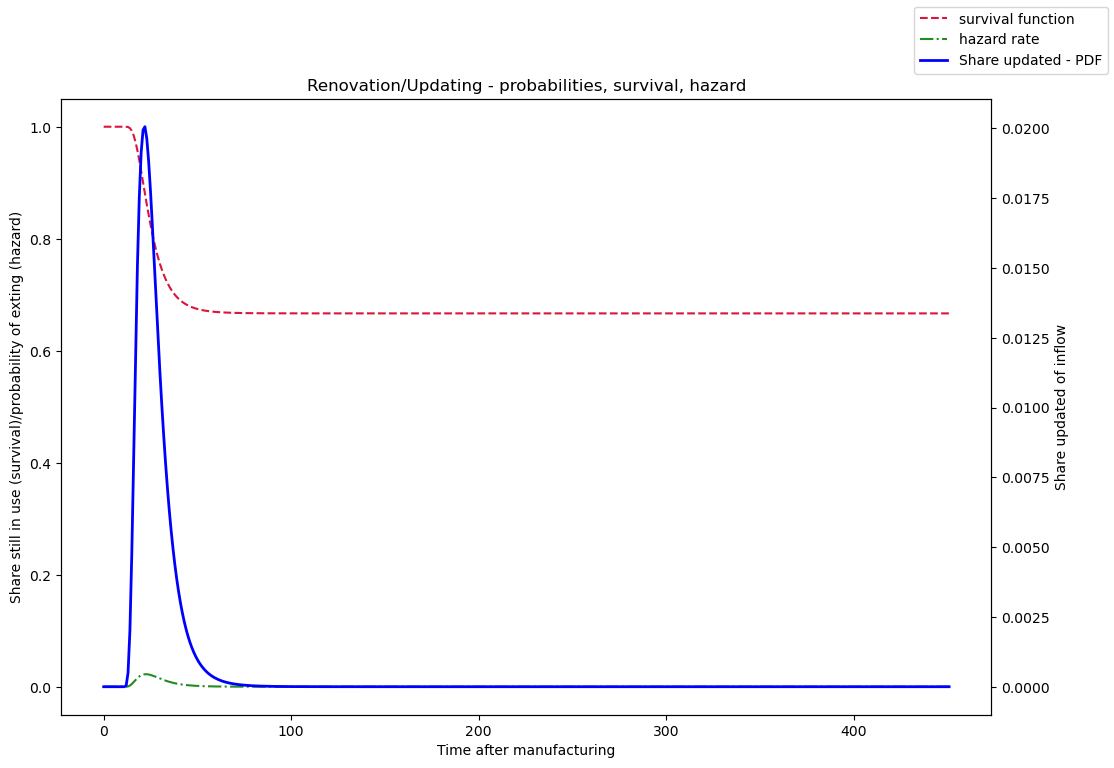

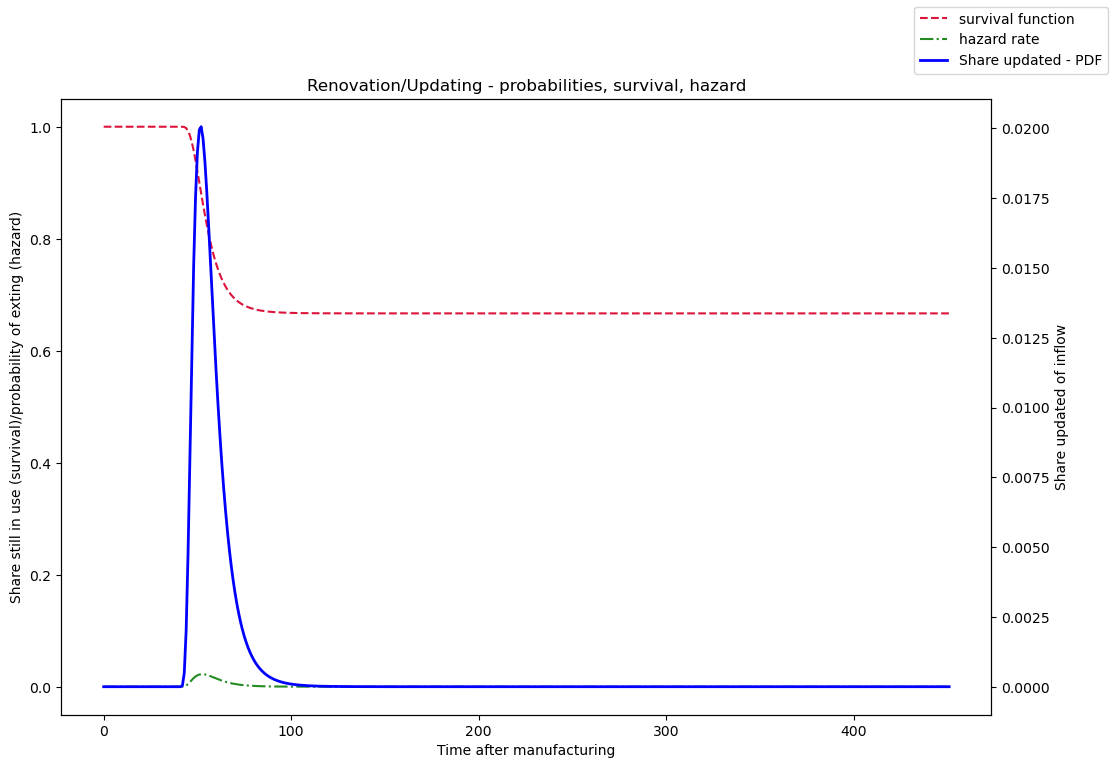

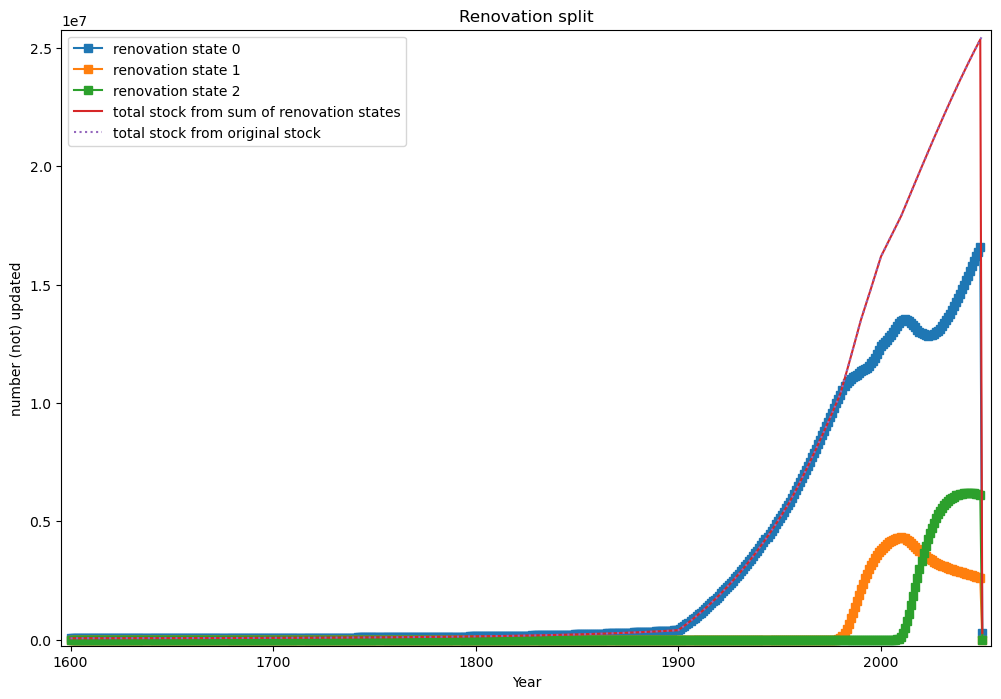

In [64]:
# Initialize the RenovationStock model for TH.
ren_stock_model_TH = RenovationStock(
    np.array(s_UFA_c_TH),
    np.array(o_TH_UFA),
    [renovation_cycle_avg, renovation_cycle_adv], s_UFA_c_SFH_df.index)

# Execute the renovation process within the model.
ren_stock_model_TH.renovate()

# Plot the total stock after renovations for TH.
ren_stock_model_TH.plot_renovation_total_stock()

# Extract the detailed stock data resolved by time and cohort after the 
# renovation processes.
stock_tcr_TH = ren_stock_model_TH.s_tc_p_r

Renovation stock model for Apartment Blocks (AB)

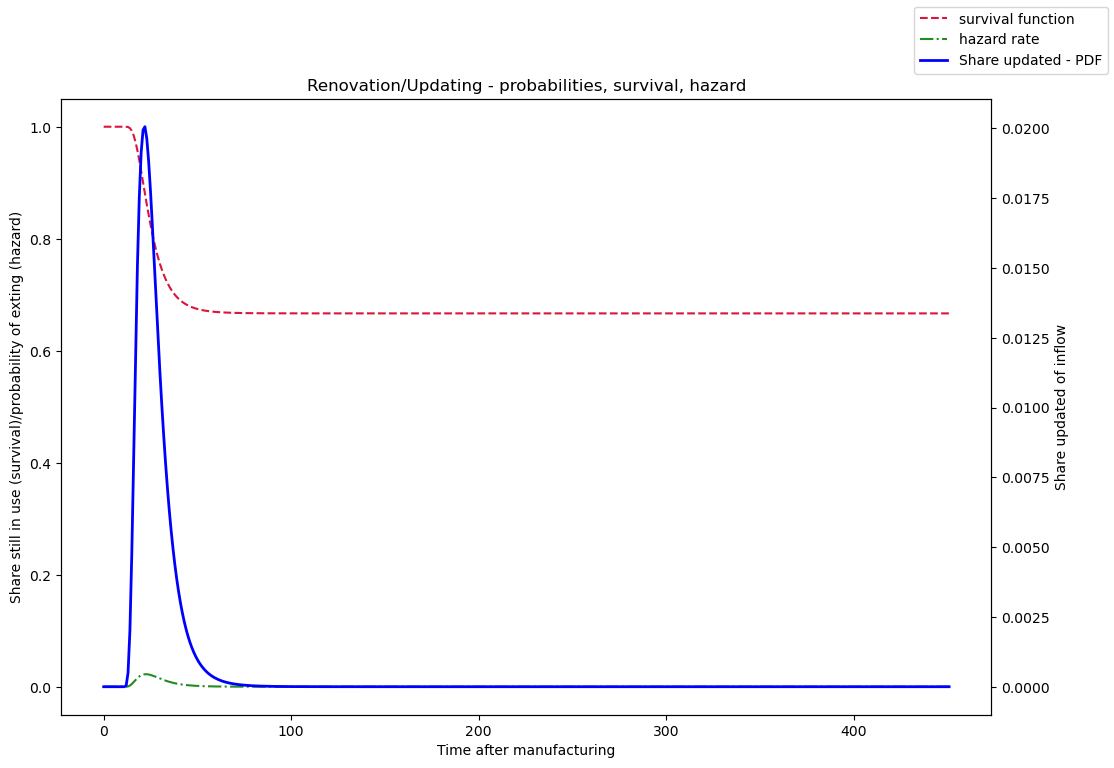

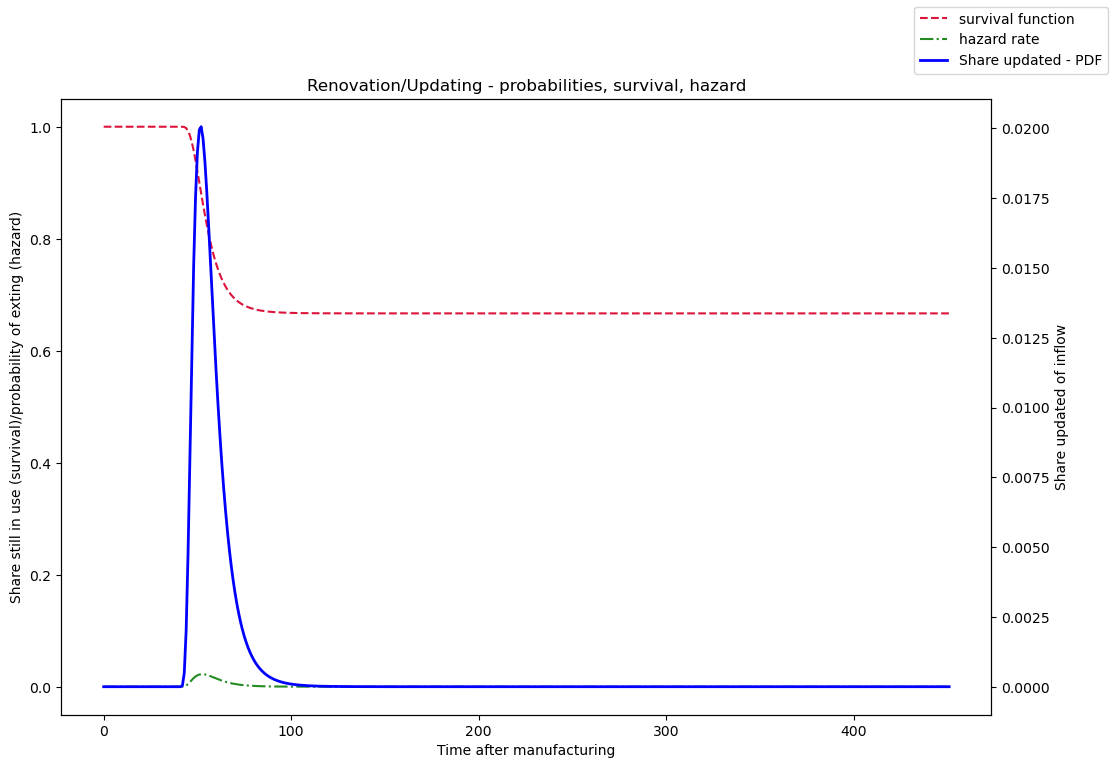

C:\Users\grace\OneDrive\Documents\Python\TEP4290_project\src/modules\renovation_state_modeling.py:387: RuntimeWarning: invalid value encountered in double_scalars
  if difference_ren_orig/np.sum(time_slice) > 0.05:


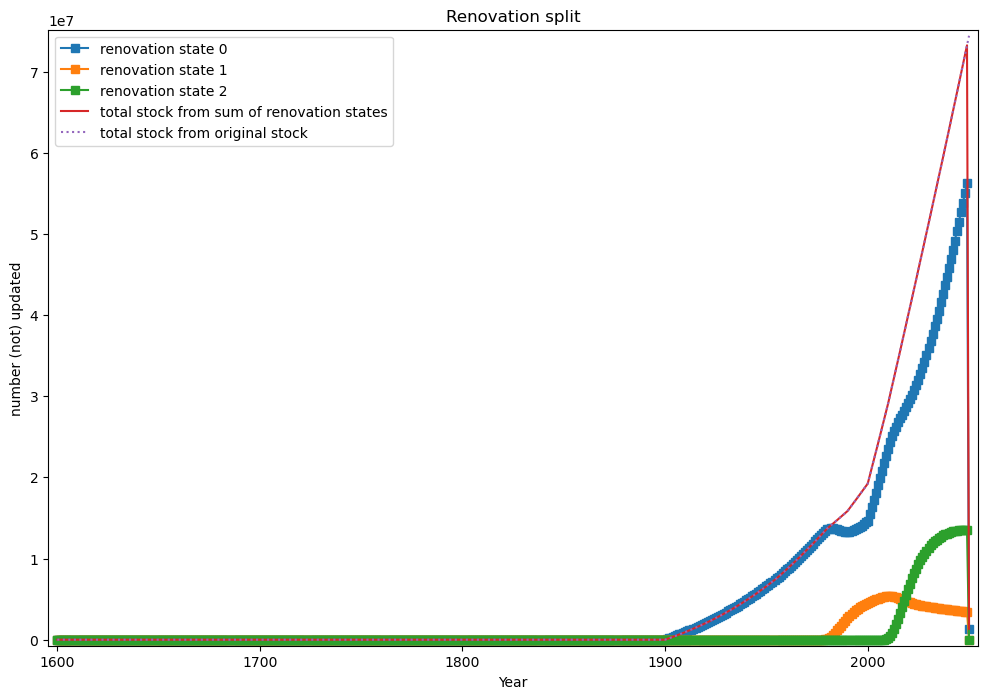

In [65]:
# Initialize the RenovationStock model for AB.
ren_stock_model_AB = RenovationStock(
    np.array(s_UFA_c_AB),
    np.array(o_AB_UFA),
    [renovation_cycle_avg, renovation_cycle_adv],
    s_UFA_c_SFH_df.index)

# Execute the renovation process within the model.
ren_stock_model_AB.renovate()

# Plot the total stock after renovations for AB.
ren_stock_model_AB.plot_renovation_total_stock()

# Extract the detailed stock data resolved by time and cohort after the 
# renovation processes.
stock_tcr_AB = ren_stock_model_AB.s_tc_p_r

### Extend energy intensity to time dimension

Single Family Homes (SFH)

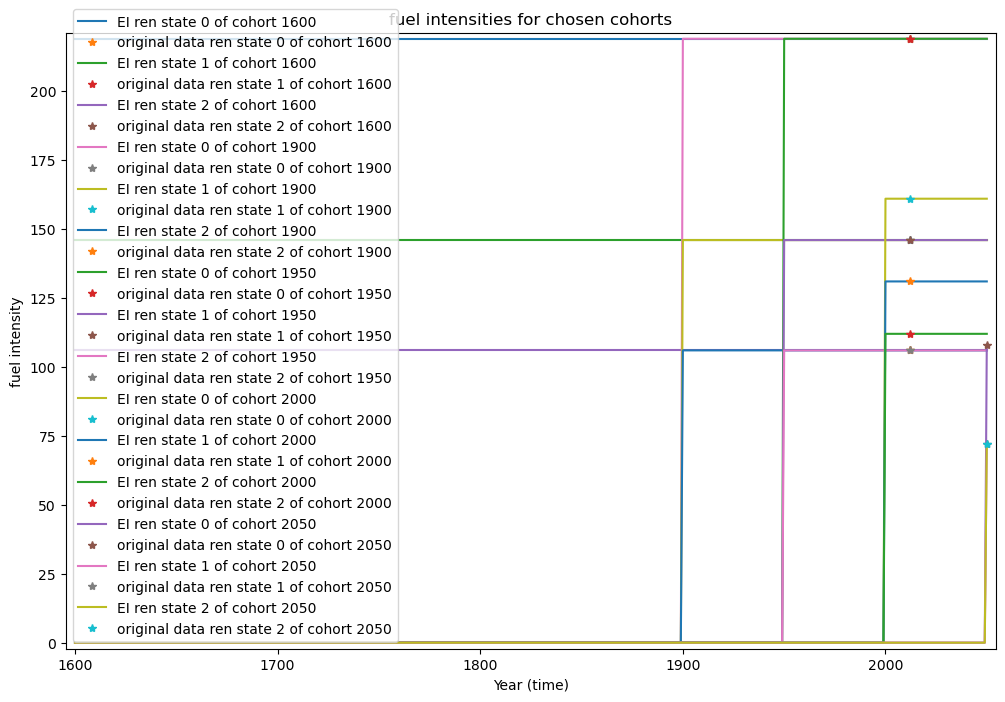

In [66]:
# Define modification parameters for energy intensity based on 
# renovation status: no renovation, average renovation, and advanced renovation.
# Each parameter set is given as [1, 1], indicating uniform adjustments across 
# different renovation scenarios.
no_ren = [1, 1]
avg_ren = [1, 1] 
adv_ren = [1, 1] 

# Initialize the EnergyIntensity model for SFH.
SFH_EI = EnergyIntensity(
    np.array(EI_SFH),
    2012,
    np.array(s_UFA_c_SFH_df.index),
    adjustment_parameters=[no_ren, avg_ren, adv_ren])

# Compute the energy intensity resolved by time and cohort post-renovation 
# using the model. 
EI_tcr_SFH = SFH_EI.EI_tc_p_r

# Plot selected energy intensity profiles at specific time steps to visually 
# assess the impact of renovations and time on energy usage.
SFH_EI.plot_some_EIs([0,300,350,400,450])

Terraced Houses (TH)

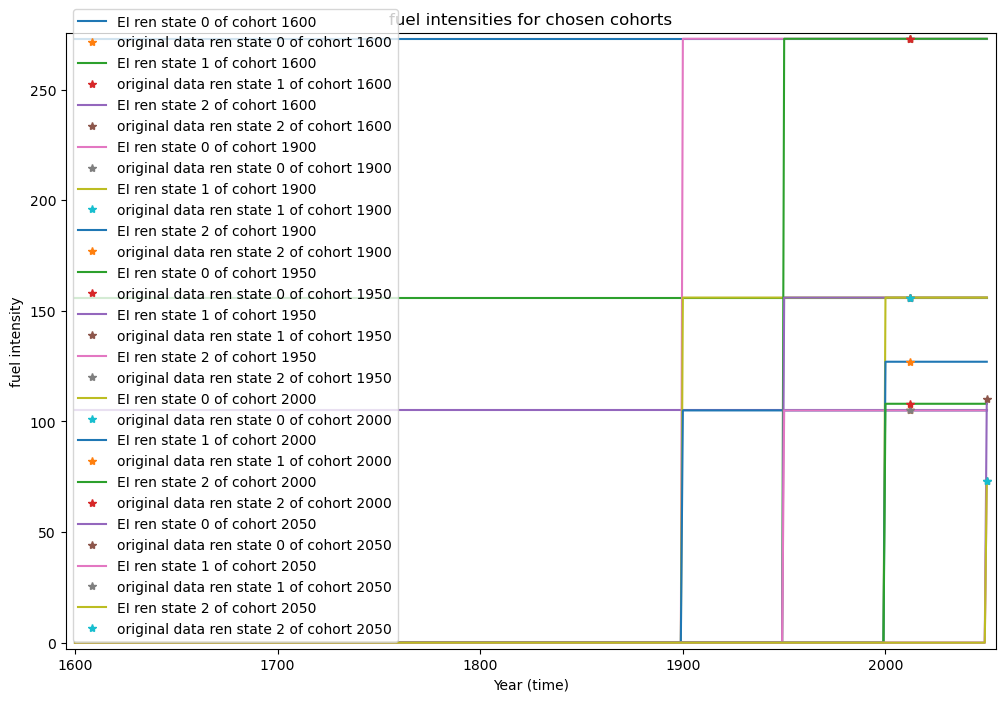

In [67]:
# Define modification parameters for energy intensity based on 
# renovation status: no renovation, average renovation, and advanced renovation.
# Each parameter set is given as [1, 1], indicating uniform adjustments across 
# different renovation scenarios.
no_ren = [1, 1]
avg_ren = [1, 1] 
adv_ren = [1, 1]

# Initialize the EnergyIntensity model for TH.
TH_EI = EnergyIntensity(
    np.array(EI_TH),
    2012,
    np.array(s_UFA_c_SFH_df.index),
    adjustment_parameters=[no_ren, avg_ren, adv_ren])

# Compute the energy intensity resolved by time and cohort post-renovation 
# using the model. 
EI_tcr_TH = TH_EI.EI_tc_p_r

# Plot selected energy intensity profiles at specific time steps to visually 
# assess the impact of renovations and time on energy usage.
TH_EI.plot_some_EIs([0,300,350,400,450])

Apartment Blocks (AB)

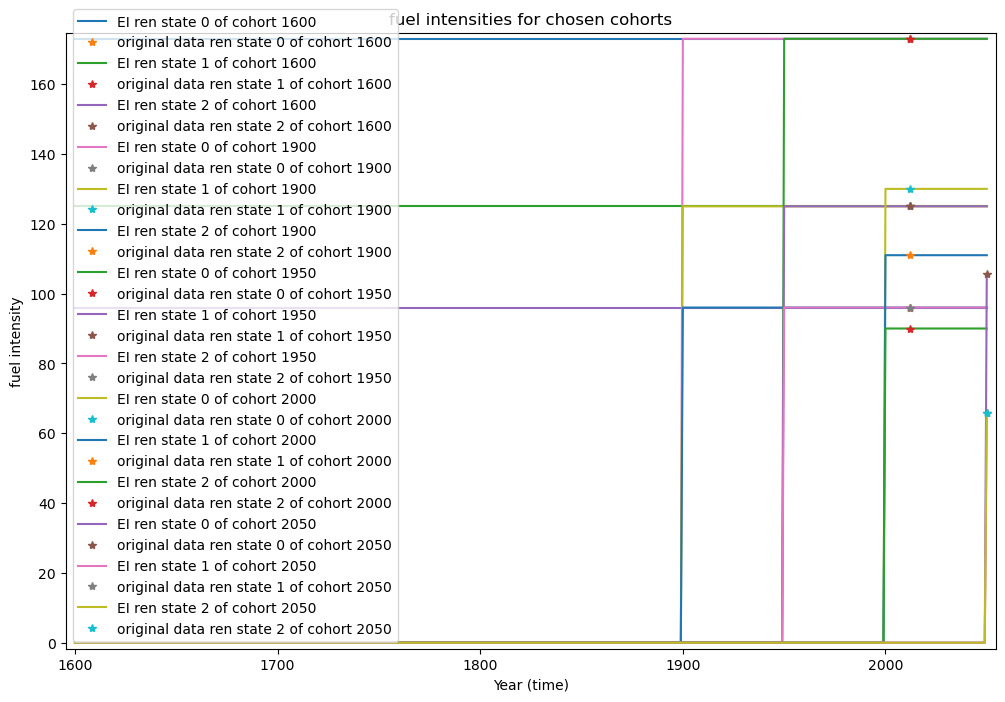

In [68]:
# Define modification parameters for energy intensity based on 
# renovation status: no renovation, average renovation, and advanced renovation.
# Each parameter set is given as [1, 1], indicating uniform adjustments across 
# different renovation scenarios.
no_ren = [1, 1]
avg_ren = [1, 1] 
adv_ren = [1, 1]

# Initialize the EnergyIntensity model for AB.
AB_EI = EnergyIntensity(
    np.array(EI_AB),
    2012,
    np.array(s_UFA_c_SFH_df.index),
    adjustment_parameters=[no_ren, avg_ren, adv_ren])

# Compute the energy intensity resolved by time and cohort post-renovation 
# using the model. 
EI_tcr_AB = AB_EI.EI_tc_p_r

# Plot selected energy intensity profiles at specific time steps to visually 
# assess the impact of renovations and time on energy usage.
AB_EI.plot_some_EIs([0,300,350,400,450])

### Calculate energy use for each dwelling type

Single Family Homes (SFH)

Text(0.5, 0, 'Year')

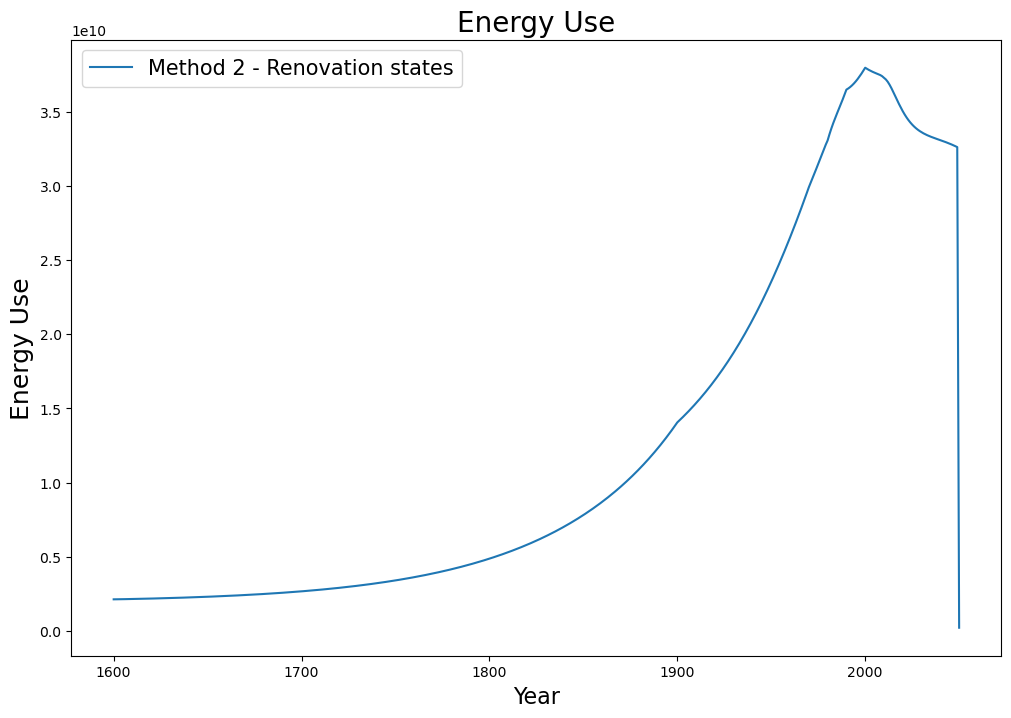

In [69]:
# Calculate energy consumption using the stock by vehicle and parts cohorts.
# Calculations done where t = time, c = cohort, and r = renovation states.
# Convert stock of vehicles to km driven.
# np.einsum('tcr, t-> tcr', stock_tcr, data['Kilometrage per vehicle'])
# Calculate fuel consumption based on vehicle efficiency.
energy_use_SFH = np.einsum('tcr, tcr->t', stock_tcr_SFH, EI_tcr_SFH)

# Compare values with previous calculations without repairs and 
#with Method 1 (Product Component Model).
fig = plt.figure(figsize=(12,8))

plt.plot(
    np.arange(1600,2051),
    energy_use_SFH,
    label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

Terraced Houses (TH)

Text(0.5, 0, 'Year')

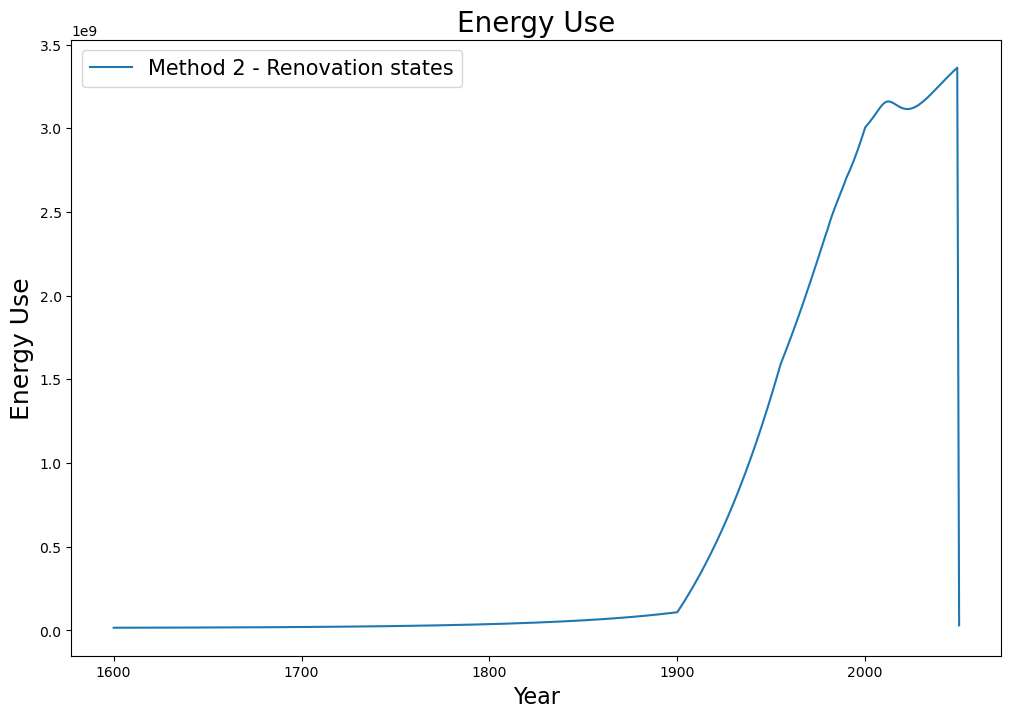

In [70]:
energy_use_TH = np.einsum('tcr, tcr->t', stock_tcr_TH, EI_tcr_TH)

# Compare values with previous calculations,
# without repairs and with Method 1 (Product Component Model).
fig = plt.figure(figsize=(12,8))

plt.plot(
    np.arange(1600,2051),
    energy_use_TH,
    label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

Apartment Blocks (AB)

Text(0.5, 0, 'Year')

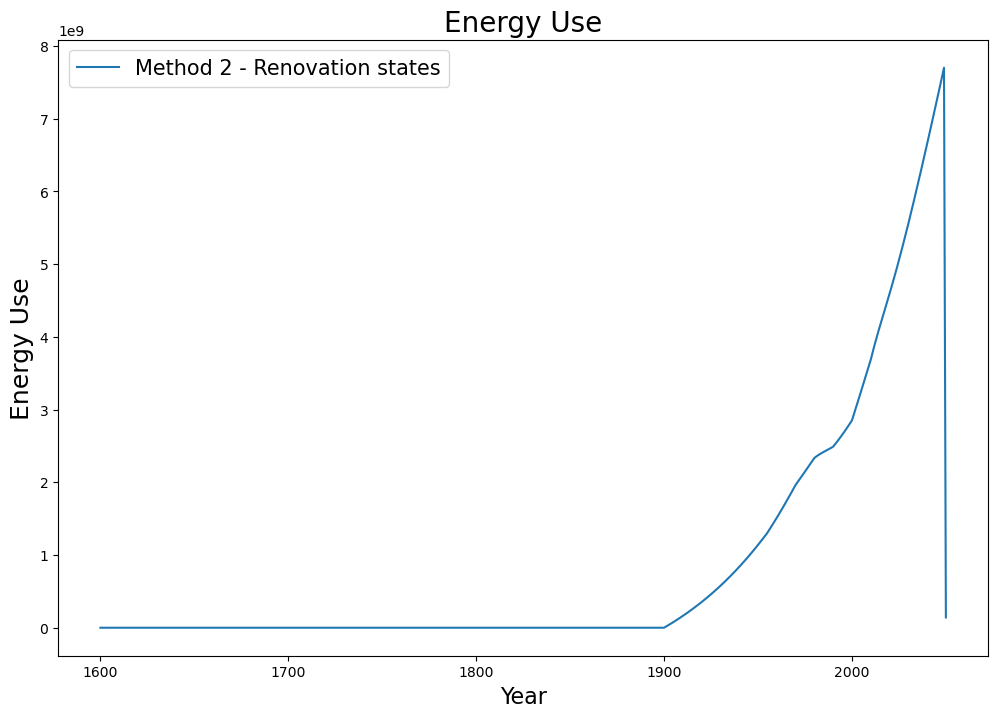

In [71]:
energy_use_AB = np.einsum('tcr, tcr->t', stock_tcr_AB, EI_tcr_AB)

# Compare values with previous calculations,
# without repairs and with Method 1 (Product Component Model).
fig = plt.figure(figsize=(12,8))

plt.plot(
    np.arange(1600,2051),
    energy_use_AB,
    label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

### Sum for total energy use

Text(0.5, 0, 'Year')

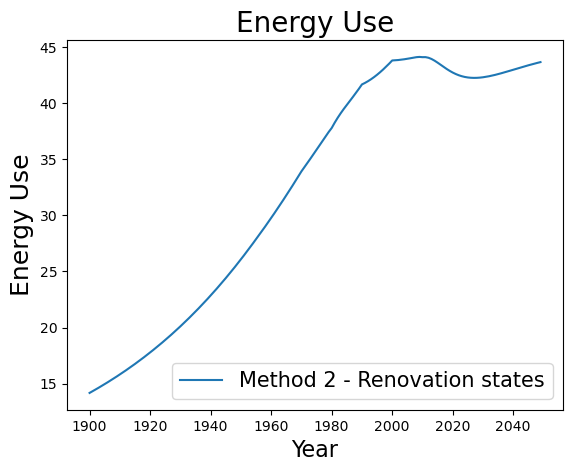

In [72]:
# Convert the numpy arrays of annual energy use for SFH, TH, AB into pandas 
# DataFrames. This facilitates the subsequent operations for summing up 
# the energy use.
energy_use_SFH_df = pd.DataFrame(energy_use_SFH)
energy_use_TH_df = pd.DataFrame(energy_use_TH)
energy_use_AB_df = pd.DataFrame(energy_use_AB)

# Calculate the total energy use by summing the energy use dataframes for 
# SFH, TH, and AB.
total_energy_use = (energy_use_SFH_df + energy_use_TH_df
                    + energy_use_AB_df)
total_energy_use

# Plot the total energy use.
plt.plot(np.arange(1900,2050),
         total_energy_use[300:450]/1000000000,
         label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

In [73]:
# Extract a portion of the 'total_energy_use' dataframe starting from the 
# index 420 onwards.
total_energy_use[420:]/1000000000

,0
420,42.752543
421,42.621690
422,42.512657
423,42.425543
424,42.359701
425,42.313985
426,42.286931
427,42.276902
428,42.282197
429,42.301104


### Extend carbon intensity to time dimension

Single Family Homes (SFH)

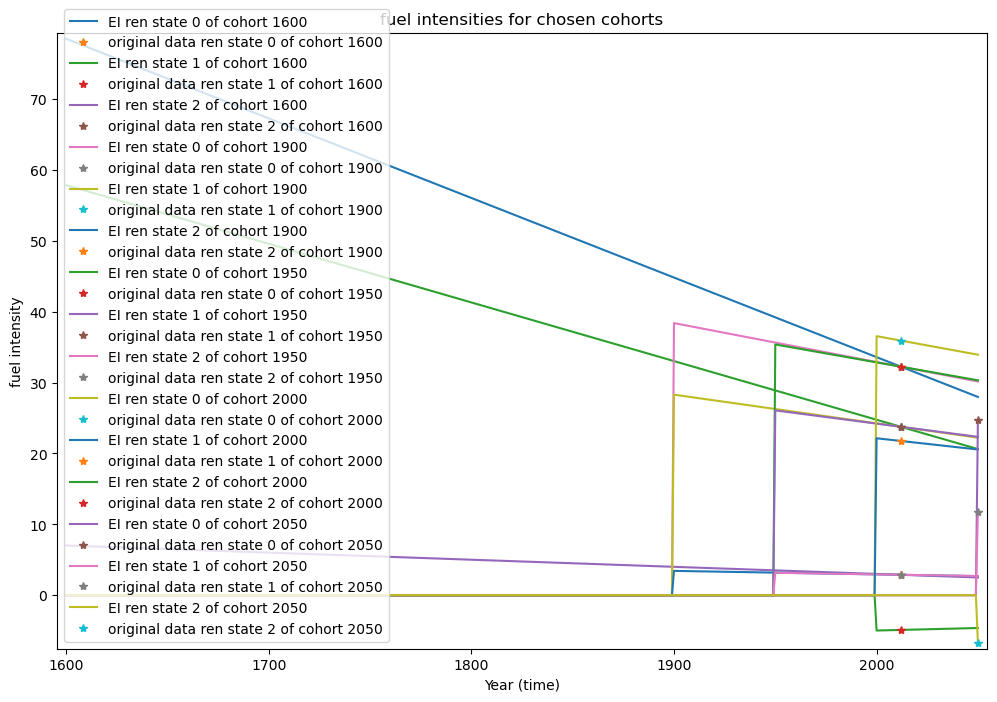

In [74]:
# Model the carbon intensity (CI) of SFH over time, taking into account 
# different states of renovation.
# source of energy intensity change over time:
# https://www.iea.org/countries/norway/emissions
no_ren_c = [2.54, 0.905] # slope of change
avg_ren_c = [2.54, 0.905] # slope of change
adv_ren_c = [2.54, 0.905] # slope of change


SFH_CI = EnergyIntensity(
    np.array(CI_SFH),
    2012,
    np.array(s_UFA_c_SFH_df.index),
    adjustment_parameters=[no_ren_c, avg_ren_c, adv_ren_c])

CI_tcr_SFH = SFH_CI.EI_tc_p_r

SFH_CI.plot_some_EIs([0,300,350,400,450])

Terraced Houses (TH)

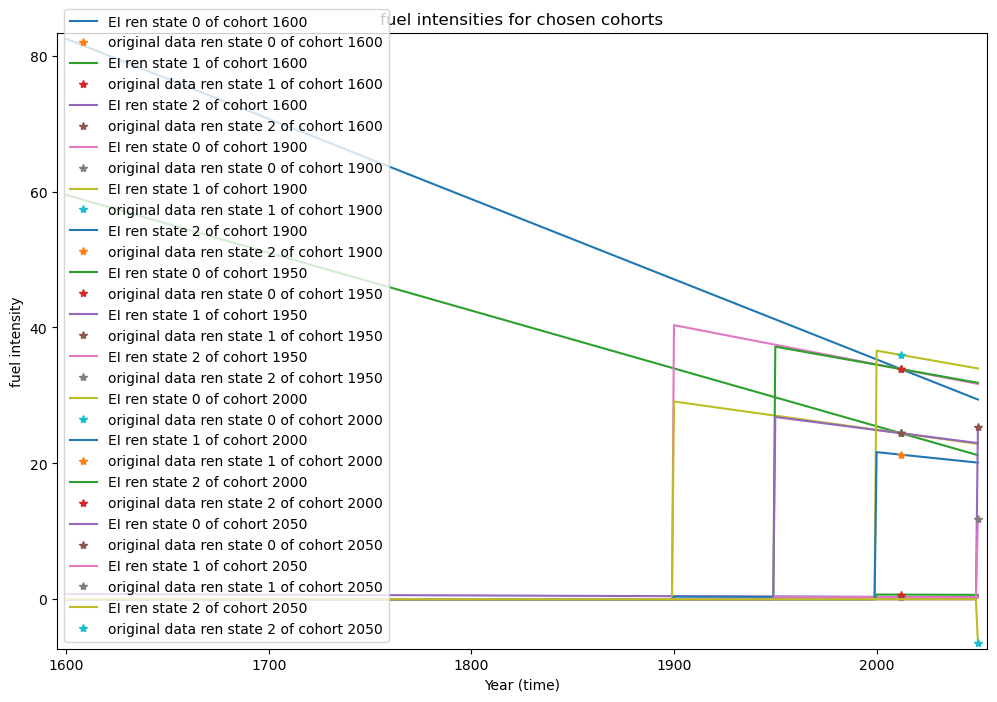

In [75]:
# Model the carbon intensity (CI) of TH over time, taking into account 
# different states of renovation.
# source of energy intensity change over time:
# https://www.eea.europa.eu/data-and-maps/figures/odyssee-energy-efficiency-index-odex-1
no_ren_c = [2.54, 0.905] # slope of change
avg_ren_c = [2.54, 0.905] # slope of change
adv_ren_c = [2.54, 0.905] # slope of change

TH_CI = EnergyIntensity(
    np.array(CI_TH),
    2012,
    np.array(s_UFA_c_SFH_df.index),
    adjustment_parameters=[no_ren_c, avg_ren_c, adv_ren_c])

CI_tcr_TH = TH_CI.EI_tc_p_r

TH_CI.plot_some_EIs([0,300,350,400,450])

Apartment Blocks (AB)

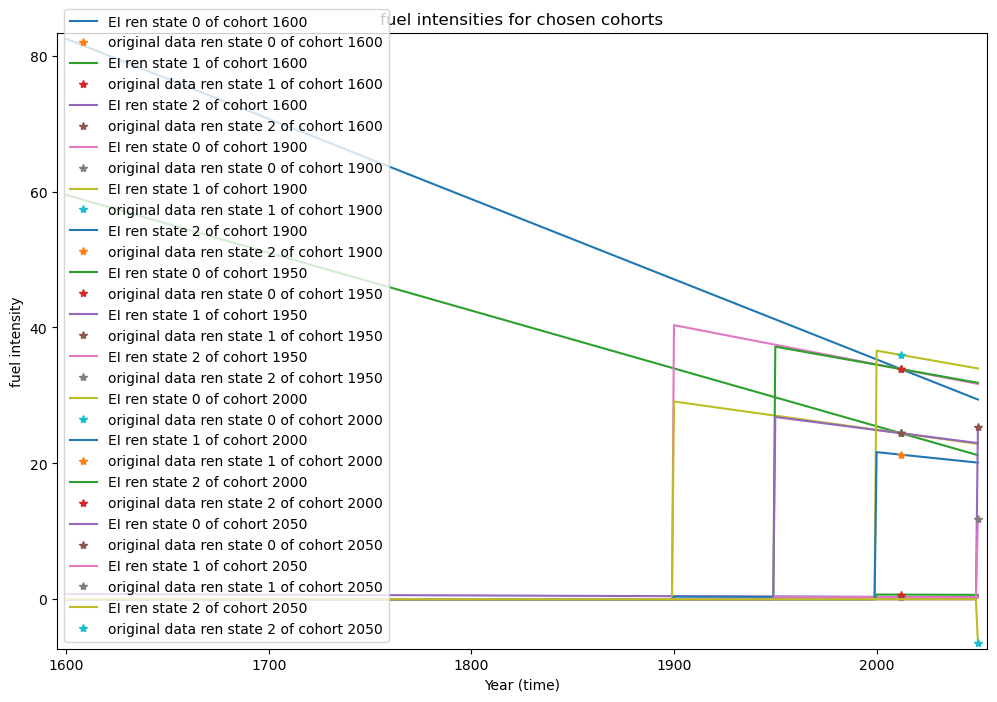

In [76]:
# Model the carbon intensity (CI) of AB over time, taking into account 
# different states of renovation.
# source of energy intensity change over time:
# https://www.eea.europa.eu/data-and-maps/figures/odyssee-energy-efficiency-index-odex-1
no_ren_c = [2.54, 0.905] # slope of change
avg_ren_c = [2.54, 0.905] # slope of change
adv_ren_c = [2.54, 0.905] # slope of change

AB_CI = EnergyIntensity(
    np.array(CI_TH),
    2012,
    np.array(s_UFA_c_SFH_df.index),
    adjustment_parameters=[no_ren_c, avg_ren_c, adv_ren_c])

CI_tcr_AB = AB_CI.EI_tc_p_r

AB_CI.plot_some_EIs([0,300,350,400,450])

### Energy consumption

Single Family Homes (SFH)

Text(0.5, 0, 'Year')

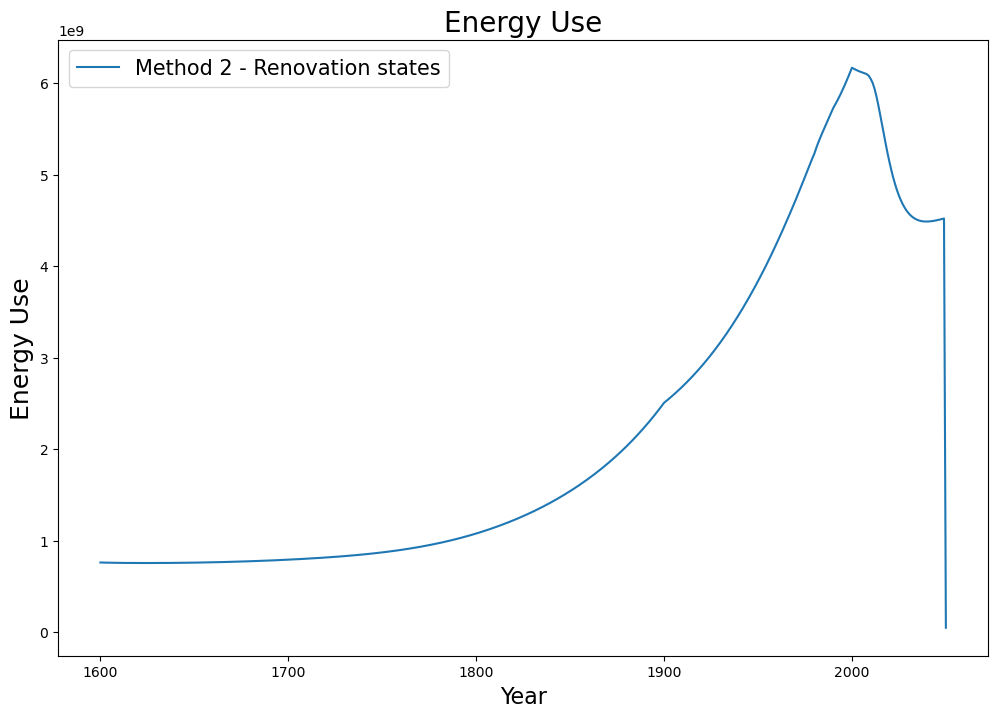

In [77]:
# Calculate energy consumption,
# using the stock by vehicle and parts cohorts.
# Calculations done where:
#  t = time, c = cohort, and r = renovation states
# Convert stock of vehicles to km driven
# km_driven = 
# np.einsum('tcr, t-> tcr', stock_tcr, data['Kilometrage per vehicle'])
# Calculate fuel consumption based on vehicle efficiency.
carbon_emissions_SFH = np.einsum('tcr, tcr->t', stock_tcr_SFH, CI_tcr_SFH)

# Compare values with previous calculations,
# without repairs and with Method 1 (Product Component Model).
fig = plt.figure(figsize=(12,8))

plt.plot(np.arange(1600,2051),
         carbon_emissions_SFH,
         label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

Terraced Houses (TH)

Text(0.5, 0, 'Year')

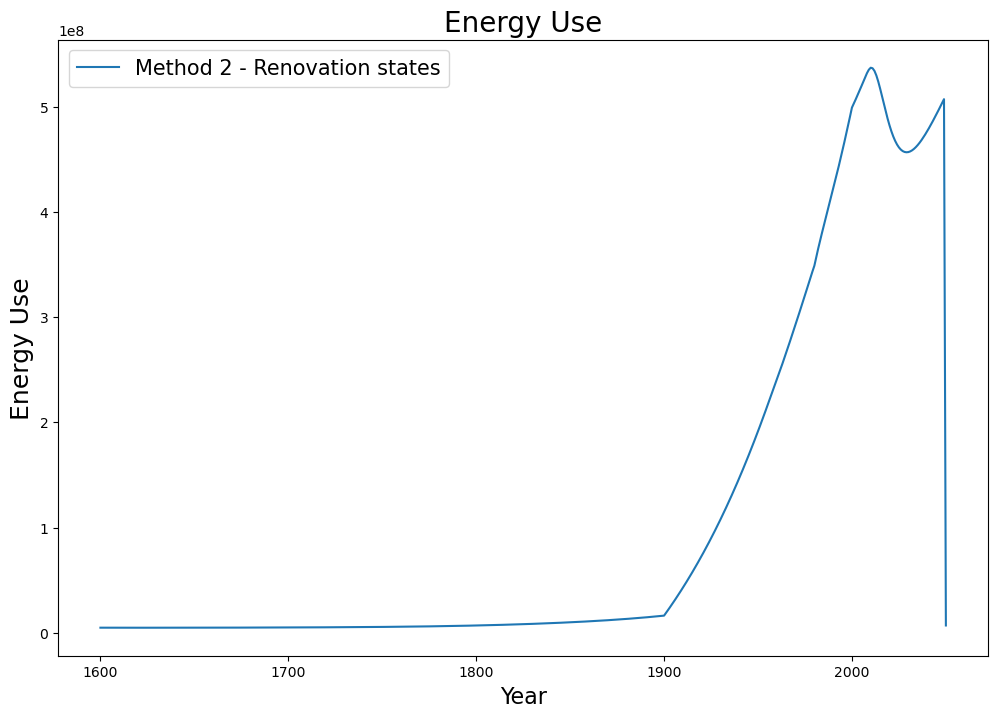

In [78]:
# Calculate energy consumption,
# using the stock by vehicle and parts cohorts.
# Calculations done where:
# t = time, c = cohort, and r = renovation states.
# Convert stock of vehicles to km driven
# km_driven = 
# np.einsum('tcr, t-> tcr', stock_tcr, data['Kilometrage per vehicle'])
# Calculate fuel consumption based on vehicle efficiency
carbon_emissions_TH = np.einsum('tcr, tcr->t', stock_tcr_TH, CI_tcr_TH)

# Compare values with previous calculations without repairs and 
# with Method 1 (Product Component Model).
fig = plt.figure(figsize=(12,8))

plt.plot(np.arange(1600,2051),
         carbon_emissions_TH,
         label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

Apartment Blocks (AB)

Text(0.5, 0, 'Year')

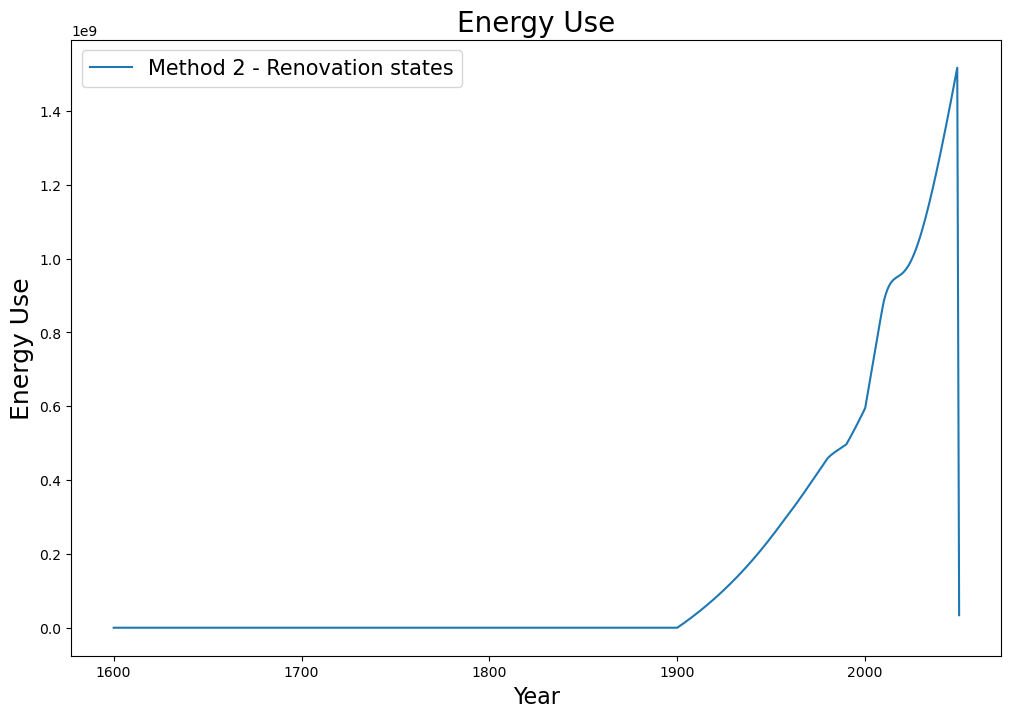

In [79]:
# Calculate energy consumption,
# using the stock by vehicle and parts cohorts
# Calculations done where:
# t = time, c = cohort, and r = renovation states
# Convert stock of vehicles to km driven
#km_driven = 
#np.einsum('tcr, t-> tcr', stock_tcr, data['Kilometrage per vehicle'])
# Calculate fuel consumption based on vehicle efficiency
carbon_emissions_AB = np.einsum('tcr, tcr->t', stock_tcr_AB, CI_tcr_AB)

# Compare values with previous calculations without repairs and 
#with Method 1 (Product Component Model)
fig = plt.figure(figsize=(12,8))

plt.plot(np.arange(1600,2051),
         carbon_emissions_AB,
         label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

### Sum total carbon emissions

Text(0.5, 0, 'Year')

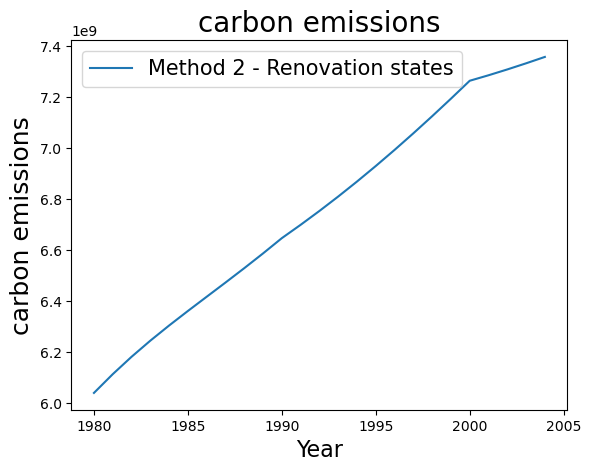

In [80]:
# Convert the numpy arrays containing carbon emissions for each dwelling 
# type into pandas DataFrames.
# Currently in million metric ton.
carbon_emissions_SFH_df = pd.DataFrame(carbon_emissions_SFH)
carbon_emissions_TH_df = pd.DataFrame(carbon_emissions_TH)
carbon_emissions_AB_df = pd.DataFrame(carbon_emissions_AB)

# Calculate the total carbon emissions by summing the emissions from SFH, TH, 
# and AB.
total_carbon_emissions = (carbon_emissions_SFH_df
                          + carbon_emissions_TH_df
                          + carbon_emissions_AB_df)
total_carbon_emissions

# Plot the total carbon emissions from the year 1980 to 2005.
plt.plot(np.arange(1980,2005),
         total_carbon_emissions[380:405],
         label='Method 2 - Renovation states')
plt.ylabel('carbon emissions',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('carbon emissions', fontsize=20)
plt.xlabel('Year',fontsize =16)

### Export plots of stock by renovation category and type

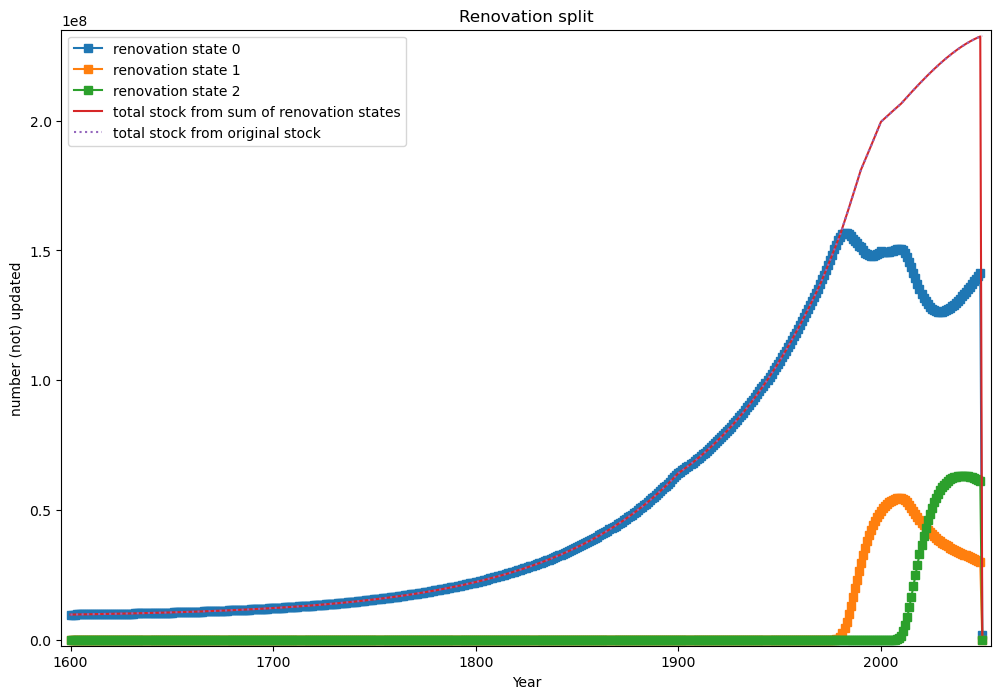

In [81]:
ren_stock_model_SFH.plot_renovation_total_stock()

### Export model outputs

In [82]:
s_SFH_df.to_excel(
    directory_path /
    'data/model_outputs_baseline/number_of_dwellings/s_SFH.xlsx')

s_TH_df.to_excel(
    directory_path /
    'data/model_outputs_baseline/number_of_dwellings/s_TH.xlsx')

s_AB_df.to_excel(
    directory_path /
    'data/model_outputs_baseline/number_of_dwellings/s_AB.xlsx')

SFH_stock_by_tabula_cohort.to_excel(
    directory_path /
    'data/model_outputs_baseline/number_of_dwellings/s_c_SFH.xlsx')

TH_stock_by_tabula_cohort.to_excel(
    directory_path /
    'data/model_outputs_baseline/number_of_dwellings/s_c_TH.xlsx')

AB_stock_by_tabula_cohort.to_excel(
    directory_path /
    'data/model_outputs_baseline/number_of_dwellings/s_c_AB.xlsx')

stock_change_total.to_excel(
    directory_path /
    'data/model_outputs_baseline/number_of_dwellings/s_delta_total.xlsx'
)

total_stock_by_tabula_cohort.to_excel(
    directory_path /
    'data/model_outputs_baseline/number_of_dwellings/s_c_total.xlsx')

pd.DataFrame(
        i_SFH
    ).to_excel(
        directory_path /
        'data/model_outputs_baseline/number_of_dwellings/i_SFH.xlsx'
    )

pd.DataFrame(
        i_TH
    ).to_excel(
        directory_path /
        'data/model_outputs_baseline/number_of_dwellings/i_TH.xlsx'
    )

pd.DataFrame(
        i_AB
    ).to_excel(
        directory_path /
        'data/model_outputs_baseline/number_of_dwellings/i_AB.xlsx'
    )

o_total.to_excel(
    directory_path /
    'data/model_outputs_baseline/number_of_dwellings/o_total.xlsx')

i_total.to_excel(
    directory_path /
    'data/model_outputs_baseline/number_of_dwellings/i_total.xlsx')

s_UFA_c_SFH_df.to_excel(
    directory_path /
    'data/model_outputs_baseline/UFA/s_UFA_c_SFH.xlsx')

s_UFA_c_TH_df.to_excel(
    directory_path /
    'data/model_outputs_baseline/UFA/s_UFA_c_TH.xlsx')

s_UFA_c_AB_df.to_excel(
    directory_path /
    'data/model_outputs_baseline/UFA/s_UFA_c_AB.xlsx')

SFH_UFA_stock_by_tabula_cohort.to_excel(
    directory_path /
    'data/model_outputs_baseline/UFA/s_UFA_tabula_SFH.xlsx')

TH_UFA_stock_by_tabula_cohort.to_excel(
    directory_path /
    'data/model_outputs_baseline/UFA/s_UFA_tabula_TH.xlsx')

AB_UFA_stock_by_tabula_cohort.to_excel(
    directory_path /
    'data/model_outputs_baseline/UFA/s_UFA_tabula_AB.xlsx')

stock_change_total_UFA.to_excel(
    directory_path /
    'data/model_outputs_baseline/UFA/s_delta_total_UFA.xlsx')

total_stock_UFA_by_tabula_cohort.to_excel(
    directory_path /
    'data/model_outputs_baseline/UFA/s_UFA_tabula_total.xlsx')

i_SFH_UFA.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/i_SFH_UFA.xlsx')

i_TH_UFA.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/i_TH_UFA.xlsx')

i_AB_UFA.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/i_AB_UFA.xlsx')

o_total_UFA.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/o_total_UFA.xlsx')

i_total_UFA.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/i_total_UFA.xlsx')
total_energy_use.to_excel(
    directory_path /
    'data/model_outputs_baseline/energy/total_energy_use.xlsx')
total_carbon_emissions.to_excel(
    directory_path /
    'data/model_outputs_baseline/energy/total_carbon_emissions.xlsx')

energy_use_SFH_df.to_excel(
    directory_path /
    'data/model_outputs_baseline/energy/energy_use_SFH.xlsx')

energy_use_TH_df.to_excel(
    directory_path /
    'data/model_outputs_baseline/energy/energy_use_TH.xlsx')

energy_use_AB_df.to_excel(
    directory_path /
    'data/model_outputs_baseline/energy/energy_use_AB.xlsx')

carbon_emissions_SFH_df.to_excel(
    directory_path /
    'data/model_outputs_baseline/energy/carbon_emissions_SFH.xlsx')

carbon_emissions_TH_df.to_excel(
    directory_path /
    'data/model_outputs_baseline/energy/carbon_emissions_TH.xlsx')

carbon_emissions_AB_df.to_excel(
    directory_path /
    'data/model_outputs_baseline/energy/carbon_emissions_AB.xlsx')